# RAW Crop

## Goal
Correlation between literacy, rainfall, and crop production across India.

It is intuitive that good rainfall is conducive to good production. How do the regions perform during poor rainfall in the rainy season?
We also want to cross match with the literacy rate of the region to see if higher levels of literacy affects crop production.

So we dive into the questions that are posed to understand and interpret the results.

## Environment Preparation and Loading of Data

### Spark Environment Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Provides findspark.init() to make pyspark importable as a regular library.
# Resource : https://pypi.org/project/findspark/
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark

### Common Imports and Functions

In [3]:
## Common Imports
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import *
import random
## Setup
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

In [4]:
# Add timing to the code
!pip install ipython-autotime
%load_ext autotime

time: 200 µs (started: 2021-12-10 03:53:20 +00:00)


In [5]:
import warnings

warnings.filterwarnings(action="ignore", message="unclosed", category=ResourceWarning)

time: 1.42 ms (started: 2021-12-10 03:53:20 +00:00)


In [6]:
## Common Operations
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

time: 8.95 ms (started: 2021-12-10 03:53:20 +00:00)


In [7]:
## Common Functionalities
### Splitting the states into respective zones
zones = { 
    'north': ['Jammu and Kashmir', 'Himachal Pradesh', 'Punjab', 'Uttarakhand', 'Uttar Pradesh', 'Haryana', 'Chandigarh', 'Delhi', 'Haryana, Delhi and Chandigarh'],
    'south': ['Andhra Pradesh', 'Karnataka', 'Kerala', 'Tamil Nadu', 'Telangana', 'Lakshadweep', 'Andaman and Nicobar Islands', 'Puducherry'],
    'east': ['Bihar', 'Orissa', 'Odisha', 'Jharkhand', 'West Bengal'],
    'west': [ 'Rajasthan' , 'Gujarat', 'Goa', 'Maharashtra', 'Dadra and Nagar Haveli'],
    'central': ['Madhya Pradesh', 'Chhattisgarh'],
    'north_east': ['Assam', 'Sikkim', 'Nagaland', 'Meghalaya', 'Manipur', 'Mizoram', 'Tripura', 'Arunachal Pradesh','Assam and Meghalaya'],
}

# Generating reverse map for State to Zone mapping
zoneMap = {}
for key in zones:
  for state in zones[key]:
    zoneMap[state] = key
# zoneMap


### Mapping state names between Crop dataset and Rainfall dataset
# since the state names are different, mapping them as below from Crop to Rainfall dataset -
stateNameCRMap = {
    'Andaman and Nicobar Islands': ['ANDAMAN & NICOBAR ISLANDS'],
    'Andhra Pradesh': ['COASTAL ANDHRA PRADESH', 'RAYALSEEMA'],
    'Arunachal Pradesh': ['ARUNACHAL PRADESH'],
    'Assam': ['ASSAM & MEGHALAYA'],
    'Bihar': ['BIHAR'],
    'Chandigarh': ['HARYANA DELHI & CHANDIGARH'],
    'Chhattisgarh': ['CHHATTISGARH'],
    'Dadra and Nagar Haveli': ['GUJARAT REGION'],
    'Goa': ['KONKAN & GOA'],
    'Gujarat': ['GUJARAT REGION', 'SAURASHTRA & KUTCH'],
    'Haryana': ['HARYANA DELHI & CHANDIGARH'],
    'Himachal Pradesh': ['HIMACHAL PRADESH'],
    'Jammu and Kashmir': ['JAMMU & KASHMIR'],
    'Jharkhand': ['JHARKHAND'],
    'Karnataka': ['SOUTH INTERIOR KARNATAKA', 'COASTAL KARNATAKA', 'NORTH INTERIOR KARNATAKA'],
    'Kerala': ['KERALA'],
    'Madhya Pradesh': ['EAST MADHYA PRADESH', 'WEST MADHYA PRADESH'],
    'Maharashtra': ['VIDARBHA', 'MATATHWADA', 'MADHYA MAHARASHTRA'],
    'Manipur': ['NAGA MANI MIZO TRIPURA'],
    'Meghalaya': ['ASSAM & MEGHALAYA'],
    'Mizoram': ['NAGA MANI MIZO TRIPURA'],
    'Nagaland': ['NAGA MANI MIZO TRIPURA'],
    'Odisha': ['ORISSA'],
    'Puducherry': ['TAMIL NADU'],
    'Punjab': ['PUNJAB'],
    'Rajasthan': ['EAST RAJASTHAN', 'WEST RAJASTHAN'],
    'Sikkim': ['SUB HIMALAYAN WEST BENGAL & SIKKIM'],
    'Tamil Nadu': ['TAMIL NADU'],
    'Telangana': ['TELANGANA'],
    'Tripura': ['NAGA MANI MIZO TRIPURA'],
    'Uttar Pradesh': ['EAST UTTAR PRADESH', 'WEST UTTAR PRADESH'],
    'Uttarakhand': ['UTTARAKHAND'],
    'West Bengal': ['GANGETIC WEST BENGAL', 'SUB HIMALAYAN WEST BENGAL & SIKKIM'],
}
stateNameRCMap = {}
# Generating reverse map
for key in stateNameCRMap:
    for region in stateNameCRMap[key]:
        # https://stackoverflow.com/a/26367880
        stateNameRCMap.setdefault(region, []).append(key)
# stateNameRCMap


## Mapping states to the zones
RainStates = {
    'Andaman and Nicobar Islands' : ['ANDAMAN & NICOBAR ISLANDS'],
    'Arunachal Pradesh' : ['ARUNACHAL PRADESH'],
    'Assam and Meghalaya' : ['ASSAM & MEGHALAYA'],
    'Bihar' : ['BIHAR'],
    'Chhattisgarh' : ['CHHATTISGARH'],
    'Andhra Pradesh' : ['COASTAL ANDHRA PRADESH','RAYALSEEMA'],
    'Karnataka' : ['COASTAL KARNATAKA','NORTH INTERIOR KARNATAKA','SOUTH INTERIOR KARNATAKA'],
    'Madhya Pradesh' : ['EAST MADHYA PRADESH','WEST MADHYA PRADESH'],
    'Rajasthan' : ['EAST RAJASTHAN','WEST RAJASTHAN'],
    'Uttar Pradesh' : ['EAST UTTAR PRADESH','WEST UTTAR PRADESH'],
    'West Bengal' : ['GANGETIC WEST BENGAL'],
    'Gujarat' : ['GUJARAT REGION','SAURASHTRA & KUTCH'],
    'Haryana, Delhi and Chandigarh' : ['HARYANA DELHI & CHANDIGARH'],
    'Himachal Pradesh' : ['HIMACHAL PRADESH'],
    'Jammu and Kashmir ' : ['JAMMU & KASHMIR'],
    'Jharkhand' : ['JHARKHAND'],
    'Kerala' : ['KERALA'],
    'Goa' : ['KONKAN & GOA'],
    'Lakshadweep' : ['LAKSHADWEEP'],
    'Maharashtra' : ['MADHYA MAHARASHTRA','MATATHWADA','VIDARBHA'],
    'Tripura' : ['NAGA MANI MIZO TRIPURA'],
    'Odisha' : ['ORISSA'],
    'Punjab' : ['PUNJAB'],
    'Sikkim' : ['SUB HIMALAYAN WEST BENGAL & SIKKIM'],
    'Tamil Nadu' : ['TAMIL NADU'],
    'Telangana' : ['TELANGANA'],
    'Uttarakhand' : ['UTTARAKHAND'],

}
RainStatesMap = {}
for key in RainStates:
  for state in RainStates[key]:
    RainStatesMap[state] = key

time: 62.3 ms (started: 2021-12-10 03:53:20 +00:00)


In [8]:
## Common Functions

### User Defined Functoin for mapping state to zone
def find_zone(state):
    # print(state)
    return zoneMap[state]

zone_udf_string = udf(lambda state: find_zone(state), StringType())

### UDF for comparing crop dataset state names with rainfall dataset state names
def isSameState(state_name1, state_name2, year1, year2):
    mapped_states = stateNameCRMap[state_name1]
    for sname in mapped_states:
        if (sname == state_name2) and (year1 == year2):
            return True
    return False

rc_state_compare_udf = udf(isSameState, BooleanType())

### UDF for mapping state names in rainfall dataset
def find_RainStates(state):
  # print(state)
  return RainStatesMap[state]

RainStates_udf_string = udf(lambda state: find_RainStates(state), StringType())

time: 16.1 ms (started: 2021-12-10 03:53:20 +00:00)


### Loading Data

In [9]:
# Crop Data
cfile = "/content/drive/Shareddrives/DA-231-O-Sem-Project-2021/data/crop/apy.csv"
_cdf = spark.read.option("header",True).option("inferSchema",True).csv(cfile)
_cdf.show(5, truncate=False)

# Water quality data
wfile = "/content/drive/Shareddrives/DA-231-O-Sem-Project-2021/data/water/water-quality-*.jsonl"
_wdf = spark.read.json(wfile)
_wdf.show(5, truncate=False)

# Rainfall Data
rfile = "/content/drive/Shareddrives/DA-231-O-Sem-Project-2021/data/rainfall/rainfall_in_india_1901-2015.csv"
_rdf = spark.read.option("header", True).option("inferSchema", True).csv(rfile)
_rdf.show(5, truncate=False)

# Literacy Data
_lfile = "/content/drive/Shareddrives/DA-231-O-Sem-Project-2021/data/literacy/GOI_Proper_Headers.csv"
_ldf = spark.read.option("header",True).option("inferSchema",True).csv(_lfile)
_ldf.show(5, truncate=False)

+---------------------------+-------------+---------+-----------+-------------------+------+----------+
|State_Name                 |District_Name|Crop_Year|Season     |Crop               |Area  |Production|
+---------------------------+-------------+---------+-----------+-------------------+------+----------+
|Andaman and Nicobar Islands|NICOBARS     |2000     |Kharif     |Arecanut           |1254.0|2000      |
|Andaman and Nicobar Islands|NICOBARS     |2000     |Kharif     |Other Kharif pulses|2.0   |1         |
|Andaman and Nicobar Islands|NICOBARS     |2000     |Kharif     |Rice               |102.0 |321       |
|Andaman and Nicobar Islands|NICOBARS     |2000     |Whole Year |Banana             |176.0 |641       |
|Andaman and Nicobar Islands|NICOBARS     |2000     |Whole Year |Cashewnut          |720.0 |165       |
+---------------------------+-------------+---------+-----------+-------------------+------+----------+
only showing top 5 rows

+-------+--------+-------+-------------

## Trend of top 5 crops per region in each season for the years 2000-2014

In [10]:
windowRegion = Window.partitionBy("RegionSeasonCrop_Year").orderBy(col("avg_production").desc())

cal_zone = _cdf.select(col("State_Name"),
                       col("District_Name"),
                       col("Crop_Year"),
                       col("Season"),
                       col("Crop"),
                       col("Area"),
                       col("Production"),
                       zone_udf_string(trim("State_Name")).alias('Region'),)\
               .filter(~(trim(col('Season')) == 'Whole Year'))\
               .withColumn("RegionSeasonCrop_Year", concat('Region', 'Season', 'Crop_Year'))

grp_statewise = cal_zone.groupBy("State_Name").agg(
                            avg("Production").alias("avg_production"),
                            avg("Area").alias("avg_area"))
grp_statewise.show(5)

+----------+------------------+------------------+
|State_Name|    avg_production|          avg_area|
+----------+------------------+------------------+
|  Nagaland|  3048.33544973545|1589.8455843469064|
| Karnataka|14795.294705261853|11063.592911580643|
|    Odisha|12531.749602947133| 8915.978395564976|
|    Kerala|11183.839801670143| 4734.655407331976|
|Tamil Nadu|25292.076732357353|11534.968876611418|
+----------+------------------+------------------+
only showing top 5 rows

time: 3.57 s (started: 2021-12-10 03:53:31 +00:00)


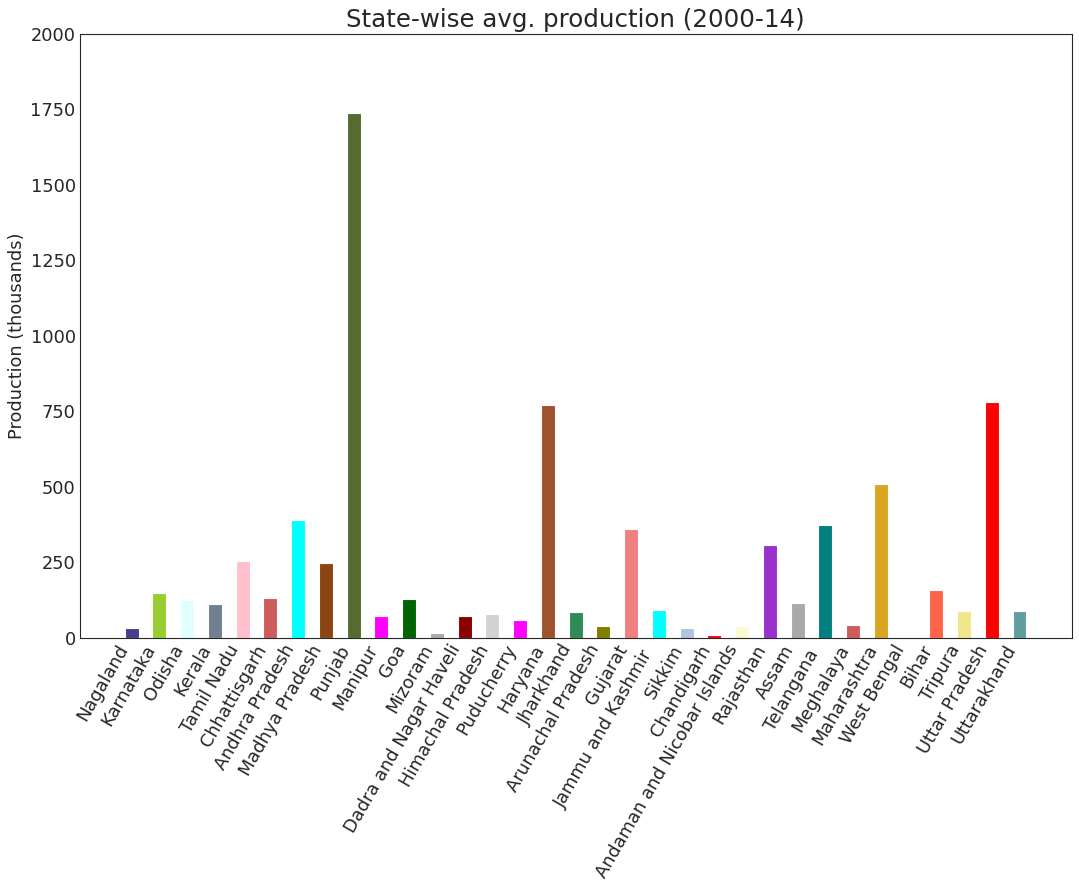

time: 4.06 s (started: 2021-12-10 03:53:35 +00:00)


In [11]:
dataf = grp_statewise.toPandas();
# Prepare Data
n = dataf['State_Name'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
c = random.choices(all_colors, k=n)

# Plot Bars
plt.figure(figsize=(16,10), dpi= 80)
plt.bar(dataf['State_Name'], dataf['avg_production']/100, color=c, width=.5)

# Decoration
plt.gca().set_xticklabels(dataf['State_Name'], rotation=60, horizontalalignment= 'right')
plt.title("State-wise avg. production (2000-14)", fontsize=22)
plt.ylabel('Production (thousands)')
plt.ylim(0, 2000)
plt.show()

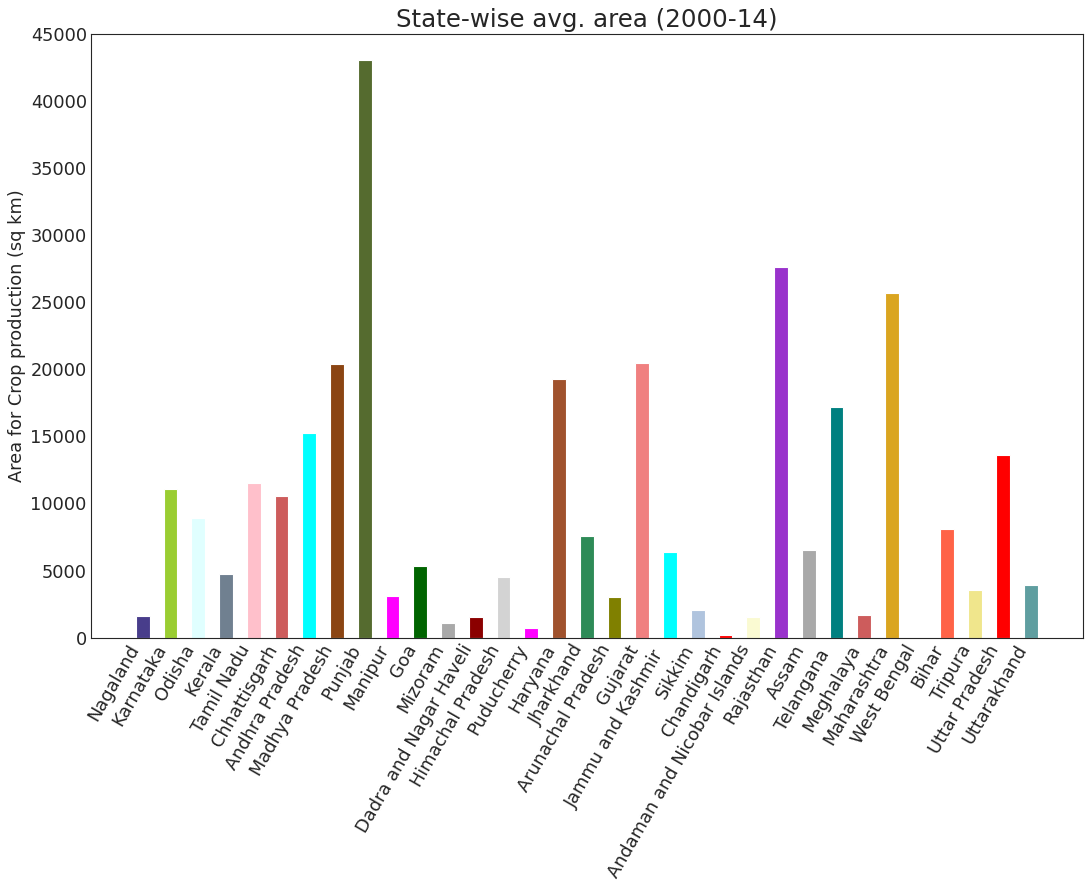

time: 595 ms (started: 2021-12-10 03:53:39 +00:00)


In [12]:
# Plot Bars
plt.figure(figsize=(16,10), dpi= 80)
plt.bar(dataf['State_Name'], dataf['avg_area'], color=c, width=.5)

# Decoration
plt.gca().set_xticklabels(dataf['State_Name'], rotation=60, horizontalalignment= 'right')
plt.title("State-wise avg. area (2000-14)", fontsize=22)
plt.ylabel('Area for Crop production (sq km)')
plt.ylim(0, 45000)
plt.show()

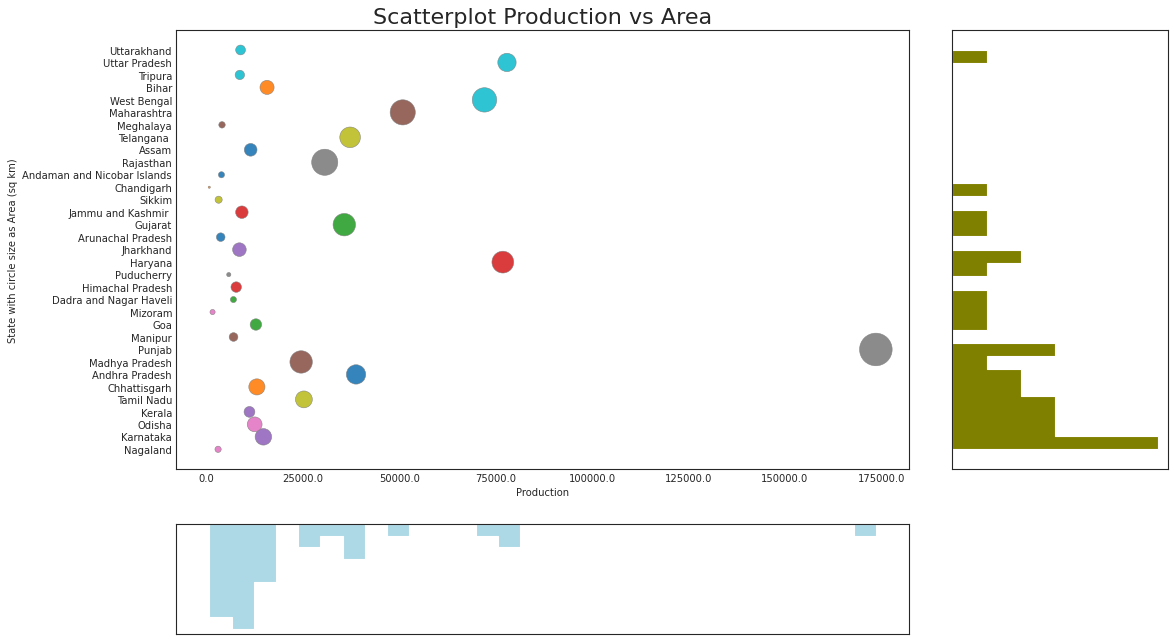

time: 826 ms (started: 2021-12-10 03:53:40 +00:00)


In [13]:
# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_centr = fig.add_subplot(grid[:-1, :-1])
ax_rgt = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bttm = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# Scatterplot on main ax
ax_centr.scatter('avg_production', 'State_Name', s=dataf.avg_area/50, c=dataf['State_Name'].astype('category').cat.codes, alpha=.9, data=dataf, cmap="tab10", edgecolors='gray', linewidths=.5)

# histogram on the bottom
ax_bttm.hist(dataf.avg_production/1000, 30, histtype='stepfilled', orientation='vertical', color='lightblue', label="Area")
ax_bttm.invert_yaxis()

# histogram in the right
ax_rgt.hist(dataf.avg_area/50, 30, histtype='stepfilled', orientation='horizontal', color='olive')

# Decorations
ax_centr.set(title='Scatterplot Production vs Area', xlabel='Production', ylabel='State with circle size as Area (sq km)')
ax_centr.title.set_fontsize(20)
for item in ([ax_centr.xaxis.label, ax_centr.yaxis.label] + ax_centr.get_xticklabels() + ax_centr.get_yticklabels()):
    item.set_fontsize(9)

xlabels = ax_centr.get_xticks().tolist()
ax_centr.set_xticklabels(xlabels)
plt.show()

In [14]:
top_crops = cal_zone.groupBy("Crop", "Crop_Year")\
                    .agg(avg("Production").alias("avg_production"),
                         sum("Production").alias("sum_production"),
                         avg("Area").alias("avg_area"),
                         sum("Area").alias("sum_area"),
                         first("Season").alias("Season"),)\
                    .sort(col("Crop"), col("Crop_Year"), col("Season"), col("avg_production").desc())
top_crops.show(5)

+--------+---------+--------------+--------------+--------+--------+-----------+
|    Crop|Crop_Year|avg_production|sum_production|avg_area|sum_area|     Season|
+--------+---------+--------------+--------------+--------+--------+-----------+
|Arecanut|     1998|          23.0|          23.0|    66.0|    66.0|Kharif     |
|Arecanut|     2000|        3600.0|        7200.0|  2177.0|  4354.0|Kharif     |
|Arecanut|     2001|        3650.0|        7300.0|  2177.0|  4354.0|Kharif     |
|Arecanut|     2006|      2080.375|       16643.0|  1518.0| 12144.0|Rabi       |
|Arecanut|     2007|          78.0|          78.0|    61.0|    61.0|Kharif     |
+--------+---------+--------------+--------------+--------+--------+-----------+
only showing top 5 rows

time: 7.79 s (started: 2021-12-10 03:53:41 +00:00)


In [15]:
windowCropProd = Window.partitionBy("t_counter").orderBy(col("t_avg_production").desc())

grp_crp = top_crops.withColumn("CROPDET", struct( "Crop", "Crop_Year", "avg_production", "avg_area", "Season"))\
                   .withColumn("counter", lit(1))\
                   .groupBy("Crop")\
                   .agg(sum("counter").alias("count"),\
                        avg("avg_production").alias("t_avg_production"),\
                        collect_list('CROPDET').alias('set_CROPDET'))\
                   .withColumn("t_counter",lit(1))\
                   .filter((col("count") > 18))\
                   .withColumn("rank",row_number().over(windowCropProd))\
                   .filter((col("rank") <= 5))\

grp_crp.show()
dataf_top_crop = grp_crp.toPandas();

# print(dataf_top_crop)

+---------+-----+------------------+--------------------+---------+----+
|     Crop|count|  t_avg_production|         set_CROPDET|t_counter|rank|
+---------+-----+------------------+--------------------+---------+----+
|Sugarcane|   19|  790396.497413747|[[Sugarcane, 1997...|        1|   1|
|    Wheat|   19| 161089.9876573991|[[Wheat, 1997, 17...|        1|   2|
|     Jute|   19|124076.92345882663|[[Jute, 1997, 134...|        1|   3|
|     Rice|   19|104846.64063169778|[[Rice, 1997, 103...|        1|   4|
| Soyabean|   19| 40833.16938767615|[[Soyabean, 1997,...|        1|   5|
+---------+-----+------------------+--------------------+---------+----+

time: 37.8 s (started: 2021-12-10 03:53:48 +00:00)


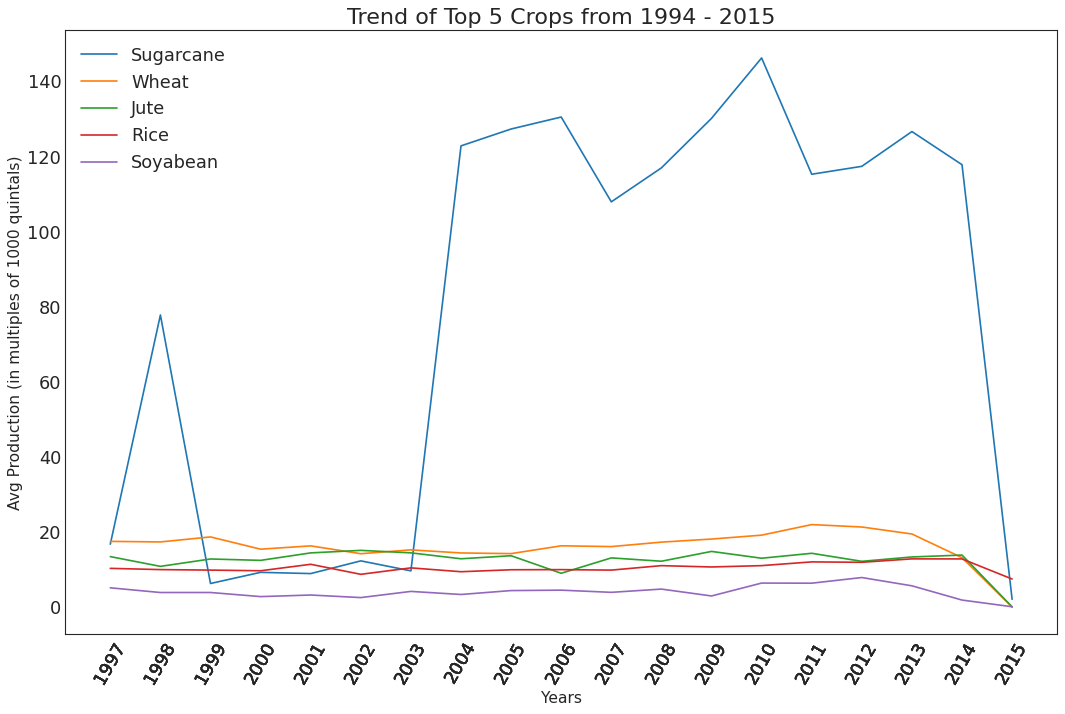

time: 3.36 s (started: 2021-12-10 03:54:26 +00:00)


In [16]:
plt.figure(figsize=(16,10), dpi= 80)
years=[]
for row in grp_crp.collect():
    # print(row)
    # print(row.set_CROPDET)
    x = []
    y = []
    for innerRow in row.set_CROPDET:
        # print(innerRow)
        if innerRow["avg_production"] is None:
            continue
        years.append(innerRow["Crop_Year"])
        x.append(innerRow["Crop_Year"])
        y.append(innerRow["avg_production"]/10000)
    plt.plot(x,y, label=row["Crop"])
# years.unique()
plt.xticks(years, years, rotation='60')
plt.title('Trend of Top 5 Crops from 1994 - 2015', fontsize=20)
plt.xlabel('Years', fontsize=14) 
plt.ylabel('Avg Production (in multiples of 1000 quintals)', fontsize=14)
plt.legend()
plt.show()

## Effect of groundwater and canal water quality on crops of a region across the years 2012-2014

### Computation of Water Quality Index(WQI)

The WQI follows the methods reported in the below reference articles and videos -
- [Development of a water quality index (WQI) for the Loktak Lake in India](https://link.springer.com/article/10.1007/s13201-017-0579-4)
- [Assessment of Water Quality Index for the
Groundwater in Tumkur Taluk,
Karnataka State, India](http://www.indiaenvironmentportal.org.in/files/water%20quality%20index.pdf)
- [Youtube: Water Quality Index](https://www.youtube.com/watch?v=HTkNmmMoUzE)
- [Youtube: Calculation of Water Quality Index](https://www.youtube.com/watch?v=LtXfIYYb8F4)
- [IITK: Information on Driking Water Quality of Institute](http://iitk.ac.in/iwd/wq/drinkingwater.htm)

In [17]:
parameters= ['bod', 'conductivity', 'do', 'fluoride', 'nitrate', 'ph', 'total_fecal']
bis_value= {
    'conductivity': 300,
    'do' : 4, 
    'bod' : 3, 
    'fluoride' :1,
    'nitrate': 45,
    'ph' : 8.5,
    'total_fecal': 5000
}
ideal_bis_value= {
    'conductivity': 0,
    'do' : 14, 
    'bod' : 0, 
    'fluoride' :0,
    'nitrate': 0,
    'ph' : 7,
    'total_fecal': 0
}

i_bis_value={}
weight_bis_value={}
sum_i_bis_value = 0
sum_weight_bis_value = 0

for key in bis_value:
  i_bis_value[key] = 1 / bis_value[key]
  sum_i_bis_value += i_bis_value[key]

k_value = 1 / sum_i_bis_value

print(i_bis_value)
print(sum_i_bis_value, k_value)

for key in bis_value:
  weight_bis_value[key] = k_value / bis_value[key]
  sum_weight_bis_value += weight_bis_value[key]

print(weight_bis_value)
print(sum_weight_bis_value)

def cal_WiQi(param_value, param_name):
  try:
    if param_value is None:
      return float(0.0)
    param_value = float(param_value)
    q_num = (param_value - ideal_bis_value[param_name])
    q_deno = (bis_value[param_name] - ideal_bis_value[param_name])
    q_n = (q_num / q_deno) * 100
    if q_n < 0:
      q_n = (q_n * (-1))
    return float((weight_bis_value[param_name]) * q_n)
  except:
    return float(0.0)

# Provide UDF for usage in Pyspark
wiqi_udf_string = udf(lambda param_value, param_name : cal_WiQi(param_value, param_name), FloatType())


{'conductivity': 0.0033333333333333335, 'do': 0.25, 'bod': 0.3333333333333333, 'fluoride': 1.0, 'nitrate': 0.022222222222222223, 'ph': 0.11764705882352941, 'total_fecal': 0.0002}
1.7267359477124182 0.579127342153733
{'conductivity': 0.0019304244738457764, 'do': 0.14478183553843324, 'bod': 0.19304244738457765, 'fluoride': 0.579127342153733, 'nitrate': 0.012869496492305177, 'ph': 0.06813262848867446, 'total_fecal': 0.0001158254684307466}
0.9999999999999999
time: 47.4 ms (started: 2021-12-10 03:54:30 +00:00)


In [18]:

# parameters= ['conductivity', 'do', 'bod', 'fluoride', 'nitrate', 'ph', 'total_fecal']
cal_wqi = _wdf.select(
    col("year"), 
    lower(trim(col("state"))).alias("State"), 
    col("location"), 
    col("data_type"), 
    col("ph_mean"), 
    col("bod_mean"), 
    col("conductivity_mean"), 
    col("do_mean"), 
    col("fluoride_mean"), 
    col("nitrate_mean"), 
    col("station_code"), 
    col("temp_mean"), 
    col("total_coliform_mean"), 
    wiqi_udf_string(("bod_mean"), lit('bod')).alias('bod_wiqi'),
    wiqi_udf_string(("conductivity_mean"), lit('conductivity')).alias('conductivity_wiqi'),
    wiqi_udf_string(("do_mean"), lit('do')).alias('do_wiqi'),
    wiqi_udf_string(("fluoride_mean"), lit('fluoride')).alias('fluoride_wiqi'),
    wiqi_udf_string(("nitrate_mean"), lit('nitrate')).alias('nitrate_wiqi'),
    wiqi_udf_string(("ph_mean"), lit('ph')).alias('ph_wiqi'),
    wiqi_udf_string(("total_coliform_mean"), lit('total_fecal')).alias('total_fecal_wiqi'),
  ).withColumn("wqi", expr('bod_wiqi + conductivity_wiqi + do_wiqi + fluoride_wiqi + nitrate_wiqi + ph_wiqi + total_fecal_wiqi')
  # ).filter(
  #      (col("wqi") < 0)
      #  (col("wqi_status").isin("Unfit For Consumption"))
  # ).withColumn("row",row_number().over(windowRegion)
  ).withColumn("state_modified",
                when(col('state') == 'tamilnadu', "tamil nadu"
                ).when(col('state') == 'haryana/cpcb', "haryana"
                ).when(col('state').isin('daman, diu, dadra nagar haveli','daman', 'daman & diu', 'dadra & nagar haveli', 'dadra nagar haveli'), "dadra and nagar haveli"
                ).when(col('state') == "jammu & kashmir", "jammu and kashmir"
                ).when(col('state') == "cpcb, delhi", "delhi"
                ).when(col('state') == "chattissgarh", "chhattissgarh"
                ).when(col('state') == "orissa", "odisha"
                ).otherwise(col("state"))
  ).groupBy("state_modified", "year" # "data_type", 
  ).agg(
      # first(col("state")),
    avg("wqi").alias("avg_wqi"),
  ).withColumn("wqi_status", 
               when(col('avg_wqi') < 25, "Excellent"
               ).when(col('avg_wqi') < 50, "Good"
               ).when(col('avg_wqi') < 75, "Poor"
               ).when(col('avg_wqi') < 100, "Very Poor"
               ).otherwise("Unfit For Consumption")
  ).filter(
       (col("avg_wqi") > 0)
  ).sort(col("state_modified"),  col("year"), col("avg_wqi") #col("data_type"),
  )

cal_wqi.show(5, truncate=False)
# cal_wqi.count()

+-----------------+----+------------------+---------------------+
|state_modified   |year|avg_wqi           |wqi_status           |
+-----------------+----+------------------+---------------------+
|andhra pradesh   |2012|127.45783972017693|Unfit For Consumption|
|andhra pradesh   |2013|126.55436060531065|Unfit For Consumption|
|andhra pradesh   |2014|138.90488023530034|Unfit For Consumption|
|arunachal pradesh|2012|10.817107439041138|Excellent            |
|assam            |2012|38.95781099319458 |Good                 |
+-----------------+----+------------------+---------------------+
only showing top 5 rows

time: 4.65 s (started: 2021-12-10 03:54:30 +00:00)


### Computation of Agricultural Efficiency

Agricultural effciency is given by

$E_i = \frac{\sum I_{ij} \times C_{ij}}{\sum C_{ij}}$

Calculation for $I_{ij}$ -

$I_{ij} = \frac{Y_{ij}}{Y_i} \times 100$

where,
- $i$ is the crop and
- $j$ is the region
- $E_{i}$ is the Agricultural Efficiency
- $I_{ij}$ is the Ratio between the yield of any crop ($Y_{ij}$) of the individual Area '$i$' under the total area and the average yield rate of the entire area'$y$' of any crop multiplied by 100
- $C_{ij}$ = Area in % for individual crop in individual area unit

#### Reference

- [How to calculate Agricultural efficiency and mapping ](https://www.youtube.com/watch?v=MB_K_a0xo3g)

In [19]:
# cropdf.printSchema()
windowRegion = Window.partitionBy("RegionSeasonCrop_Year").orderBy(col("avg_production").desc())

cal_zone = _cdf.select(
        col("State_Name"), 
        col("District_Name"), 
        col("Crop_Year"), 
        col("Season"), 
        col("Crop"), 
        col("Area"), 
        col("Production"), 
        zone_udf_string(trim("State_Name")).alias('Region'),
    ).filter(
            (~(trim(col('Season')) == 'Whole Year'))
        &   (col("Crop_Year").isin(2012, 2013, 2014))
    ).withColumn("State_Name_Year", lower(concat('State_Name', 'Crop_Year'))
    ).withColumn("State_Crop_Year", lower(concat('State_Name', 'Crop', 'Crop_Year'))
    ).withColumn("State_District_Year", lower(concat('State_Name', 'District_Name', 'Crop_Year'))
    ).withColumn("State_District_Crop_Year", lower(concat('State_Name', 'District_Name',  'Crop', 'Crop_Year'))
    )

# print(cal_zone.count())
# cal_zone.show(5, truncate=False)

sum_prod = cal_zone.groupBy("State_District_Crop_Year" #"State_Name", "Crop", "Crop_Year"
    ).agg(
        sum("Area").alias('sum_Area'),
        # lower(first("State_Name")).alias('Crop_State'),
        # first("Crop"),
        # first("Season"),
        sum("Production").alias("sum_production"),
        # avg("Area").alias("avg_area"),
    ).sort(col("State_District_Crop_Year"),  col("sum_Area") , col("sum_production"),
    )
# print(sum_prod.count())
# sum_prod.show(20, truncate=False)

percentage_prod = cal_zone.join(
        sum_prod,
        (
            (cal_zone.State_District_Crop_Year ==  sum_prod.State_District_Crop_Year)
        ),
        "inner"
        # Area percentage C(ij)
    ).withColumn("percent_area", ((col("Area") * 100)/ col("sum_Area"))
    # Yield Y(ij)
    ).withColumn("yield", (col("Production") / col("Area"))
    # ).withColumn("percent_prod", ((col("Production") * 100)/ col("sum_production"))
    )
# print(percentage_prod.count())
# percentage_prod.show(5, truncate=False)

yield_avg = percentage_prod.groupBy("State_Crop_Year" #"State_Name", "Crop", "Crop_Year"
    ).agg(
        # Y(i)
        avg("yield").alias("avg_yield"),
    ).sort(col("State_Crop_Year"),  col("avg_yield"),
    )
# yield_avg.show(5, truncate=False)

percentage_yield_prod = percentage_prod.join(
        yield_avg,
        (
            (percentage_prod.State_Crop_Year ==  yield_avg.State_Crop_Year)
        ),
        "inner"
    # I(ij)
    ).withColumn("percent_yield", ((col("yield") * 100)/ col("avg_yield"))
    # I(ij) x C(ij)
    ).withColumn("efficiency_per_crop", (col("percent_yield") * col("percent_area"))
    # ).withColumn("percent_prod", ((col("Production") * 100)/ col("sum_production"))
    )
# percentage_yield_prod.show(20, truncate=False)
  
# State_District_Year
efficiency_df = percentage_yield_prod.groupBy("State_District_Year" #"State_Name", "Crop", "Crop_Year"
    ).agg(
        first("State_Name_Year").alias('State_Name_Year'),
        first("State_Name").alias('State_Name'),
        first("Crop_Year").alias('Crop_Year'),
        sum("percent_area").alias("sum_Yield"),
        sum("efficiency_per_crop").alias("sum_efficiency_per_district"),
    ).withColumn("efficiency_per_district", (col("sum_efficiency_per_district") / col("sum_Yield"))
    ).sort(col("State_District_Year"),  col("sum_Yield"),
    )
efficiency_df.show(5, truncate=False)

grp_statewise = efficiency_df.groupBy("State_Name_Year" #"State_Name", "Crop", "Crop_Year"
    ).agg(
        first("Crop_Year").alias('Crop_Year'),
        lower(first("State_Name")).alias('Crop_State'),
        avg("efficiency_per_district").alias("efficiency_per_state"),
    ).sort(col("State_Name_Year"),  col("efficiency_per_state") #col("data_type"),
    )
# print(grp_statewise.count())
grp_statewise.show(5, truncate=False)

+---------------------------+------------------+--------------+---------+---------+---------------------------+-----------------------+
|State_District_Year        |State_Name_Year   |State_Name    |Crop_Year|sum_Yield|sum_efficiency_per_district|efficiency_per_district|
+---------------------------+------------------+--------------+---------+---------+---------------------------+-----------------------+
|andhra pradeshanantapur2012|andhra pradesh2012|Andhra Pradesh|2012     |3700.0   |322735.27987776685         |87.22575131831536      |
|andhra pradeshanantapur2013|andhra pradesh2013|Andhra Pradesh|2013     |4000.0   |351460.3951984018          |87.86509879960046      |
|andhra pradeshanantapur2014|andhra pradesh2014|Andhra Pradesh|2014     |4000.0   |338846.8436114159          |84.71171090285397      |
|andhra pradeshchittoor2012 |andhra pradesh2012|Andhra Pradesh|2012     |3800.0   |334795.6885886458          |88.10412857595941      |
|andhra pradeshchittoor2013 |andhra pradesh2013|

### Combining WQI and Agricultural Efficiency

In [20]:
combined_df = cal_wqi.join(
        grp_statewise,
        (
            (cal_wqi.year ==  grp_statewise.Crop_Year) 
            &
            (cal_wqi.state_modified ==  grp_statewise.Crop_State)
        ),
        "inner"
    ).withColumn("2012_wqi", when(col("year").isin(2012),col("avg_wqi")).otherwise(lit(0.0))
    ).withColumn("2013_wqi", when(col("year").isin(2013),col("avg_wqi")).otherwise(lit(0.0))
    ).withColumn("2014_wqi", when(col("year").isin(2014),col("avg_wqi")).otherwise(lit(0.0))
    ).withColumn("2012_eiff", when(col("year").isin(2012),col("efficiency_per_state")).otherwise(lit(0.0))
    ).withColumn("2013_eiff", when(col("year").isin(2013),col("efficiency_per_state")).otherwise(lit(0.0))
    ).withColumn("2014_eiff", when(col("year").isin(2014),col("efficiency_per_state")).otherwise(lit(0.0))
    ).groupBy("state_modified").agg(
        sum("2012_wqi").alias("2012_wqi"),
        sum("2013_wqi").alias("2013_wqi"),
        sum("2014_wqi").alias("2014_wqi"),
        sum("2012_eiff").alias("2012_eiff"),
        sum("2013_eiff").alias("2013_eiff"),
        sum("2014_eiff").alias("2014_eiff"),
    ).filter(
        ((~(col("2012_wqi") == 0.0))
        & (~(col("2013_wqi") == 0.0))
        & (~(col("2014_wqi") == 0.0)))
        | ((~(col("2012_eiff") == 0.0))
        & (~(col("2013_eiff") == 0.0))
        & (~(col("2014_eiff") == 0.0)))
    ).sort(col("state_modified")#,  col("year"), col("avg_wqi") #col("data_type"),
    )

combined_df.show(5, truncate=False)
combined_df.count()

+----------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|state_modified        |2012_wqi          |2013_wqi          |2014_wqi          |2012_eiff         |2013_eiff         |2014_eiff         |
+----------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|andhra pradesh        |127.45783972017693|126.55436060531065|138.90488023530034|101.77786531013012|100.31485464949711|99.41054604319594 |
|assam                 |38.95781099319458 |29.11172342777252 |26.259941928386688|100.70133003519595|100.15603597801862|100.2854789933227 |
|bihar                 |36.033361662615526|16.624159705283038|22.091031127380877|99.86137729767954 |100.0522380849604 |100.68668977846609|
|chhattisgarh          |27.39777500288827 |22.8699064122306  |24.20482963985867 |98.11095989515267 |96.37566666516692 |96.95047144155643 |
|dadra and nagar haveli|40.

17

time: 56.3 s (started: 2021-12-10 03:55:20 +00:00)


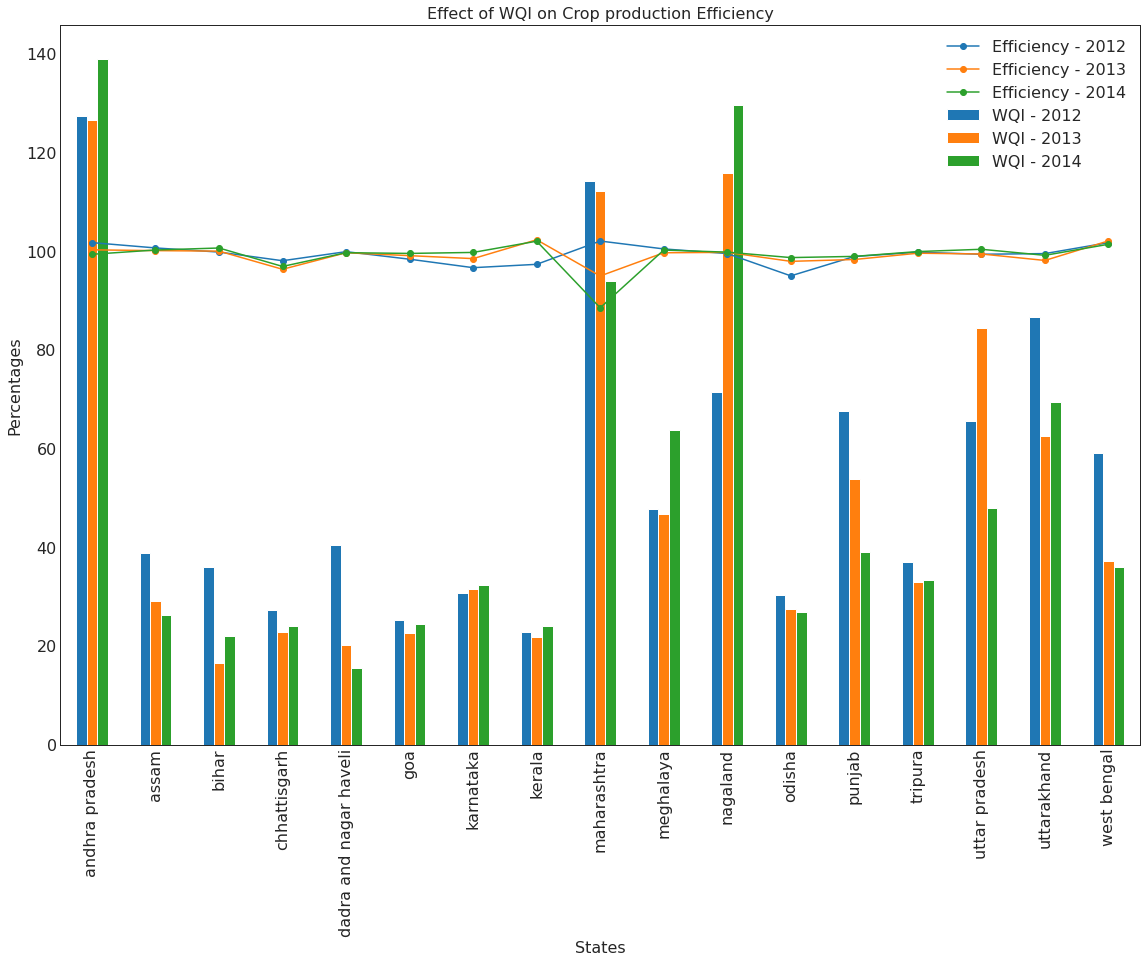

time: 27.8 s (started: 2021-12-10 03:56:16 +00:00)


In [21]:
dataSet = combined_df.toPandas();

ax = dataSet[['state_modified', '2012_eiff', '2013_eiff', '2014_eiff']].plot(
    x='state_modified', linestyle='solid', marker='o', title='Effect of WQI on Crop production Efficiency')
dataSet[['state_modified', '2012_wqi', '2013_wqi', '2014_wqi']].plot(x='state_modified', kind='bar', ax=ax)

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


set_size(15,10)
ax.set_xlabel("States")
ax.set_ylabel("Percentages")
ax.legend(["Efficiency - 2012", "Efficiency - 2013", "Efficiency - 2014", "WQI - 2012", "WQI - 2013", "WQI - 2014"]);
plt.show()

## Effect of rainfall on production of kharif crops for the years 2000-2014

### Rainfall by Region

In [22]:
_cdf = _cdf.withColumn("Production", col("Production").cast("double"))\
  .withColumn("Area", col("Area").cast("double")) 

_rdf = _rdf.withColumn("JAN", col("JAN").cast("double")).withColumn("FEB", col("FEB").cast("double")) \
            .withColumn("MAR", col("MAR").cast("double")).withColumn("APR", col("APR").cast("double")) \
            .withColumn("MAY", col("MAY").cast("double")).withColumn("JUN", col("JUN").cast("double")) \
            .withColumn("JUL", col("JUL").cast("double")).withColumn("AUG", col("AUG").cast("double")) \
            .withColumn("SEP", col("SEP").cast("double")).withColumn("OCT", col("OCT").cast("double")) \
            .withColumn("NOV", col("NOV").cast("double")).withColumn("DEC", col("DEC").cast("double")) \
            .withColumn("ANNUAL", col("ANNUAL").cast("double")).withColumn("Jan-Feb", col("Jan-Feb").cast("double")) \
            .withColumn("Mar-May", col("Mar-May").cast("double")).withColumn("Jun-Sep", col("Jun-Sep").cast("double")) .withColumn("Oct-Dec", col("Oct-Dec").cast("double"))

time: 284 ms (started: 2021-12-10 03:56:44 +00:00)


In [23]:
_rdfFilter = _rdf.select("*",RainStates_udf_string(trim("SUBDIVISION")).alias('State_Name')) \
        .where((col("YEAR") > "1999") & (col("YEAR") < "2015"))  

_rdfStates = _rdfFilter.select("State_Name","YEAR","ANNUAL","Jan-Feb","Mar-May","Jun-Sep","Oct-Dec",zone_udf_string(trim("State_Name")).alias('Region')).groupBy("Region","YEAR") \
        .agg((sum("ANNUAL")/1000).alias("ANNUAL"),(sum("Jan-Feb")/1000).alias("Jan-Feb"),(sum("Mar-May")/1000).alias("Mar-May"),(sum("Jun-Sep")/1000).alias("Jun-Sep"),(sum("Oct-Dec")/1000).alias("Oct-Dec")).orderBy("YEAR")

_rdfStateS = _rdfStates.where(col("Region") == "south").orderBy("YEAR")
_rdfStateN = _rdfStates.where(col("Region") == "north").orderBy("YEAR")
_rdfStateE = _rdfStates.where(col("Region") == "east").orderBy("YEAR")
_rdfStateW = _rdfStates.where(col("Region") == "west").orderBy("YEAR")

dataRainStateS = _rdfStateS.toPandas()
dataRainStateN = _rdfStateN.toPandas()
dataRainStateE = _rdfStateE.toPandas()
dataRainStateW = _rdfStateW.toPandas()

time: 11 s (started: 2021-12-10 03:56:44 +00:00)


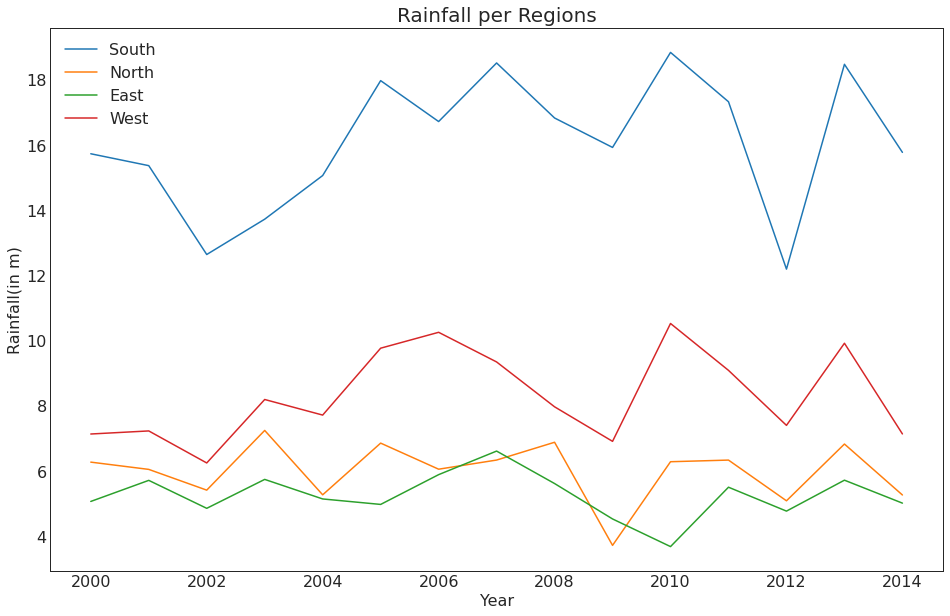

time: 540 ms (started: 2021-12-10 03:56:55 +00:00)


In [24]:
# Plot Bars
fig, ax = plt.subplots()
fig.set_size_inches(16,10)
ax.plot(dataRainStateS['YEAR'],dataRainStateS['ANNUAL'],label='South')
ax.plot(dataRainStateN['YEAR'],dataRainStateN['ANNUAL'],label='North')
ax.plot(dataRainStateE['YEAR'],dataRainStateE['ANNUAL'],label='East')
ax.plot(dataRainStateW['YEAR'],dataRainStateW['ANNUAL'],label='West')
leg = ax.legend()
ax.set(title='Rainfall per Regions',xlabel='Year',ylabel='Rainfall(in m)')
ax.title.set_fontsize(20)

### Comparing Production vs Rainfall

In [25]:
windowSpecRegion  = Window.partitionBy("cdfRegion").orderBy("Crop_Year")
windowSpecRegionCrop  = Window.partitionBy("Crop").orderBy("Crop_Year")

_rdfFilter = _rdf.select("*",RainStates_udf_string(trim("SUBDIVISION")).alias('State_Name')) \
        .where((col("YEAR") > "1999") & (col("YEAR") < "2015"))    

_cdfFilter = _cdf.select("*",zone_udf_string(trim("State_Name")).alias('Region')) \
        .where((rtrim(col("Season"))=="Kharif") & (col("Crop_Year") > "1999") & (col("Crop_Year") < "2015") & (col("Production").isNotNull())) \
        .withColumn("cdfRegionYear", concat('Region','Crop_Year') )


_rdfAct = _rdfFilter.select ("YEAR","ANNUAL","Jan-Feb","Mar-May","Jun-Sep","Oct-Dec",zone_udf_string(trim("State_Name")).alias('Region')) \
        .withColumn("rdfRegionYear", concat('Region', 'YEAR') ).groupBy("rdfRegionYear","Region").agg((sum("ANNUAL")/1000).alias("ANNUAL"),(sum("Jan-Feb")/1000).alias("Jan-Feb"),(sum("Mar-May")/1000).alias("Mar-May"),(sum("Jun-Sep")/1000).alias("Jun-Sep"),(sum("Oct-Dec")/1000).alias("Oct-Dec"))

cdfAgg = _cdfFilter.groupBy("cdfRegionYear","Crop","Region","Crop_Year").agg(sum("Production").alias("TotalProduction"),sum("Area").alias("TotalArea")).withColumnRenamed("Region","cdfRegion")
cdfrdfAct = cdfAgg.join(_rdfAct,cdfAgg.cdfRegionYear == _rdfAct.rdfRegionYear).select("cdfRegionYear","cdfRegion","Crop","Crop_Year","TotalProduction","TotalArea","ANNUAL","Jun-Sep","Oct-Dec")


cdfrdfActRegion = cdfrdfAct.groupBy("cdfRegionYear","cdfRegion","Crop_Year","Jun-Sep","Oct-Dec").agg(sum("TotalProduction").alias("TotalProduction"),sum("TotalArea").alias("TotalArea")) \
          .withColumn("PrevYearTotProd",lag("TotalProduction").over(windowSpecRegion)) \
          .withColumn("PrevYearTotArea",lag("TotalArea").over(windowSpecRegion)) \
          .withColumn("PrevYearJun-Sep",lag("Jun-Sep").over(windowSpecRegion)).cache()

cdfrdfFinalSouth1 = cdfrdfActRegion.select("*").where(col("cdfRegion") == "south") 
cdfrdfFinalNorth1 = cdfrdfActRegion.select("*").where(col("cdfRegion") == "north") 
cdfrdfFinalEast1 = cdfrdfActRegion.select("*").where(col("cdfRegion") == "east") 
cdfrdfFinalWest1 = cdfrdfActRegion.select("*").where(col("cdfRegion") == "west") 
cdfrdfFinalCentral1 = cdfrdfActRegion.select("*").where(col("cdfRegion") == "central") 

cdfrdfFinalCor1 = cdfrdfActRegion.withColumn("Corr",((col("PrevYearTotProd")/col("PrevYearTotArea"))-(col("TotalProduction")/col("TotalArea")))/(col("PrevYearJun-Sep")-col("Jun-Sep"))) \
                .withColumn("ProductionPerArea",(col("TotalProduction")/col("TotalArea"))) \
                .withColumn("Crop_Year", col("Crop_Year").cast("int")).orderBy(col("Crop_Year")).select("Crop_Year","Jun-Sep","ProductionPerArea","Corr","cdfRegion")

cdfrdfFinalSouthCor1 = cdfrdfFinalSouth1.withColumn("CorrSouth",((col("PrevYearTotProd")/col("PrevYearTotArea"))-(col("TotalProduction")/col("TotalArea")))/(col("PrevYearJun-Sep")-col("Jun-Sep"))) \
                .withColumn("ProductionPerArea",(col("TotalProduction")/col("TotalArea"))).withColumn("Region",lit("South")) \
                .withColumn("Crop_Year", col("Crop_Year").cast("int")).orderBy(col("Crop_Year")).select("Crop_Year","Jun-Sep","ProductionPerArea","CorrSouth","Region")

cdfrdfFinalNorthCor1 = cdfrdfFinalNorth1.withColumn("CorrNorth",((col("PrevYearTotProd")/col("PrevYearTotArea"))-(col("TotalProduction")/col("TotalArea")))/(col("PrevYearJun-Sep")-col("Jun-Sep"))) \
                .withColumn("ProductionPerArea",(col("TotalProduction")/col("TotalArea"))).withColumn("Region",lit("North")) \
                .withColumn("Crop_Year", col("Crop_Year").cast("int")).orderBy(col("Crop_Year")).select("Crop_Year","Jun-Sep","ProductionPerArea","CorrNorth","Region")

cdfrdfFinalEastCor1 = cdfrdfFinalEast1.withColumn("CorrEast",((col("PrevYearTotProd")/col("PrevYearTotArea"))-(col("TotalProduction")/col("TotalArea")))/(col("PrevYearJun-Sep")-col("Jun-Sep"))) \
                .withColumn("ProductionPerArea",(col("TotalProduction")/col("TotalArea"))).withColumn("Region",lit("East")) \
                .withColumn("Crop_Year", col("Crop_Year").cast("int")).orderBy(col("Crop_Year")).select("Crop_Year","Jun-Sep","ProductionPerArea","CorrEast","Region")

cdfrdfFinalWestCor1 = cdfrdfFinalWest1.withColumn("CorrWest",((col("PrevYearTotProd")/col("PrevYearTotArea"))-(col("TotalProduction")/col("TotalArea")))/(col("PrevYearJun-Sep")-col("Jun-Sep"))) \
                .withColumn("ProductionPerArea",(col("TotalProduction")/col("TotalArea"))).withColumn("Region",lit("West")) \
                .withColumn("Crop_Year", col("Crop_Year").cast("int")).orderBy(col("Crop_Year")).select("Crop_Year","Jun-Sep","ProductionPerArea","CorrWest","Region")


cdfrdfActCrop = cdfrdfAct.groupBy("Crop_Year","Crop").agg(sum("TotalProduction").alias("TotalProduction"),sum("TotalArea").alias("TotalArea"),sum("Jun-Sep").alias("Jun-Sep")) \
          .withColumn("PrevYearTotProd",lag("TotalProduction").over(windowSpecRegionCrop)) \
          .withColumn("PrevYearTotArea",lag("TotalArea").over(windowSpecRegionCrop)) \
          .withColumn("PrevYearJun-Sep",lag("Jun-Sep").over(windowSpecRegionCrop))

cdfrdfFinal1Cor = cdfrdfActCrop.withColumn("Corr",((col("PrevYearTotProd")/col("TotalArea"))-(col("TotalProduction")/col("TotalArea")))/(col("PrevYearJun-Sep")-col("Jun-Sep"))) \
                .withColumn("ProductionPerArea",(col("TotalProduction")/col("TotalArea"))) \
                .withColumn("Crop_Year", col("Crop_Year").cast("int")).orderBy(col("Crop_Year"))


time: 1.24 s (started: 2021-12-10 03:56:56 +00:00)


In [26]:
dataSetSouth1 = cdfrdfFinalSouthCor1.toPandas()
dataSetNorth1 = cdfrdfFinalNorthCor1.toPandas()
dataSetEast1 = cdfrdfFinalEastCor1.toPandas()
dataSetWest1 = cdfrdfFinalWestCor1.toPandas()

time: 20 s (started: 2021-12-10 03:56:57 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


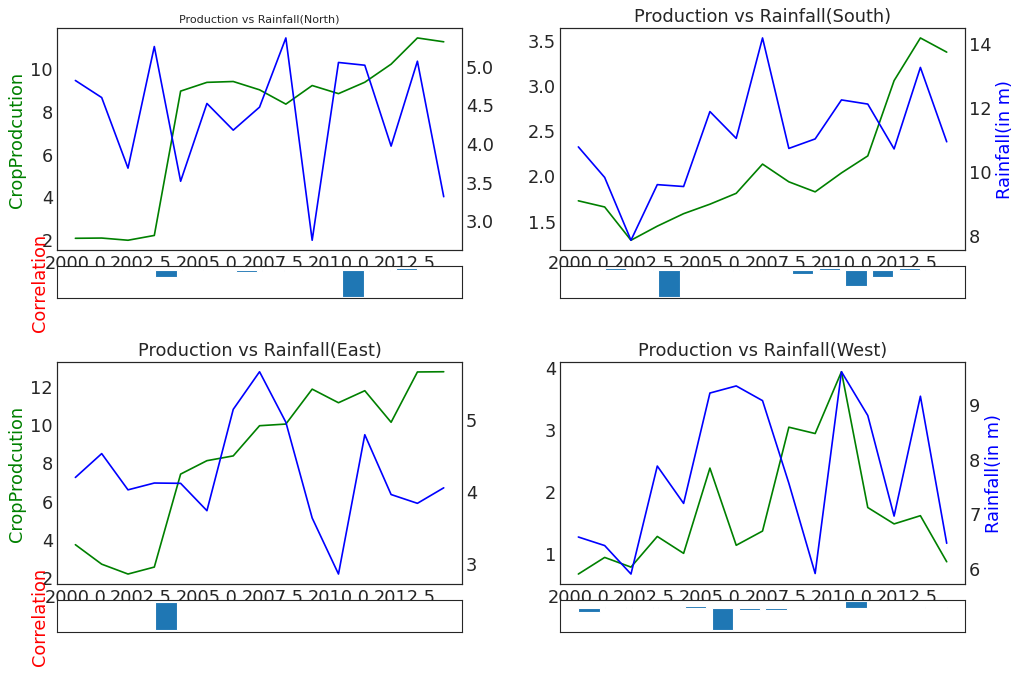

time: 3.09 s (started: 2021-12-10 03:57:17 +00:00)


In [27]:
#plt.bar(dataps2['Crop_Year'], dataps2['Cal'])
# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(13, 12, hspace=0.5, wspace=0.2)

# Define the axes
ax_n1 = fig.add_subplot(grid[0:5, 0:5])
ax_n2 = fig.add_subplot(grid[0:5, 0:5])
ax_n3 = fig.add_subplot(grid[5:6, 0:5], xticklabels=[], yticklabels=[])
ax_s1 = fig.add_subplot(grid[0:5, 6:11])
ax_s2 = fig.add_subplot(grid[0:5, 6:11])
ax_s3 = fig.add_subplot(grid[5:6, 6:11], xticklabels=[], yticklabels=[])
ax_e1 = fig.add_subplot(grid[7:12, 0:5])
ax_e2 = fig.add_subplot(grid[7:12, 0:5])
ax_e3 = fig.add_subplot(grid[12:, 0:5], xticklabels=[], yticklabels=[])
ax_w1 = fig.add_subplot(grid[7:12, 6:11])
ax_w2 = fig.add_subplot(grid[7:12, 6:11])
ax_w3 = fig.add_subplot(grid[12:, 6:11], xticklabels=[], yticklabels=[])

#ax_n1.plot('Crop_Year', 'ProductionPerArea', data=dataps2)
ax_n2 = ax_n1.twinx()
ax_n1.plot(dataSetNorth1['Crop_Year'], dataSetNorth1['ProductionPerArea'],'g-' )
ax_n2.plot(dataSetNorth1['Crop_Year'], dataSetNorth1['Jun-Sep'],'b-' )
ax_n3.bar(dataSetNorth1['Crop_Year'], dataSetNorth1['CorrNorth'] )

ax_s2 = ax_s1.twinx()
ax_s1.plot(dataSetSouth1['Crop_Year'], dataSetSouth1['ProductionPerArea'],'g-' )
ax_s2.plot(dataSetSouth1['Crop_Year'], dataSetSouth1['Jun-Sep'],'b-' )
ax_s3.bar(dataSetSouth1['Crop_Year'], dataSetSouth1['CorrSouth'] )

ax_e2 = ax_e1.twinx()
ax_e1.plot(dataSetEast1['Crop_Year'], dataSetEast1['ProductionPerArea'],'g-' )
ax_e2.plot(dataSetEast1['Crop_Year'], dataSetEast1['Jun-Sep'],'b-' )
ax_e3.bar(dataSetEast1['Crop_Year'], dataSetEast1['CorrEast'] )

ax_w2 = ax_w1.twinx()
ax_w1.plot(dataSetWest1['Crop_Year'], dataSetWest1['ProductionPerArea'],'g-' )
ax_w2.plot(dataSetWest1['Crop_Year'], dataSetWest1['Jun-Sep'],'b-' )
ax_w3.bar(dataSetWest1['Crop_Year'], dataSetWest1['CorrWest'] )

# Decorations
ax_n1.set_ylabel('CropProdcution', color='g')
ax_s2.set_ylabel('Rainfall(in m)', color='b')
ax_n3.set_ylabel('Correlation', color='r')
ax_e1.set_ylabel('CropProdcution', color='g')
ax_w2.set_ylabel('Rainfall(in m)', color='b')
ax_e3.set_ylabel('Correlation', color='r')
ax_n1.set(title='Production vs Rainfall(North)')
ax_s1.set(title='Production vs Rainfall(South)')
ax_e1.set(title='Production vs Rainfall(East)')
ax_w1.set(title='Production vs Rainfall(West)')
ax_n1.title.set_fontsize(10)
#for item in ([ax_n1.xaxis.label, ax_n1.yaxis.label] + ax_centr.get_xticklabels() + ax_centr.get_yticklabels()):
#    item.set_fontsize(9)


## Correlation of Literacy and Rainfall on Kharif Crops

### Exploration of Data

In [28]:
filtered_crop_1 = _cdf.where((col("Crop_Year")==2001)).withColumn("scaledProduce", col("Production")/100).select(col("State_Name"),col("scaledProduce")).groupBy("State_Name").agg(mean('scaledProduce')).withColumnRenamed("avg(scaledProduce)", "totalScaledProduce").select(col("State_Name"), col("totalScaledProduce"))
filtered_crop_11 = _cdf.where((col("Crop_Year")==2011)).withColumn("scaledProduce", col("Production")/100).select(col("State_Name"),col("scaledProduce")).groupBy("State_Name").agg(mean('scaledProduce')).withColumnRenamed("avg(scaledProduce)", "totalScaledProduce").select(col("State_Name"), col("totalScaledProduce"))

filtered_lit = _ldf.where(col("Category") == "State")

filtered_crop_11.show(5)

filtered_lit.show(5)

+----------+------------------+
|State_Name|totalScaledProduce|
+----------+------------------+
|  Nagaland|30.401607717041813|
| Karnataka|450.14306580829805|
|    Odisha|119.80092703150908|
|    Kerala| 314534.6091338624|
|Tamil Nadu| 69411.00933481153|
+----------+------------------+
only showing top 5 rows

+--------+-------------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+
|Category|Country_States_Union_Territories_Name|Literacy_Rate_Persons_Total_2001|Literacy_Rate_Persons_Total_2011|Literacy_Rate_Persons_Rural_2001|Literacy_Rate_Persons_Rural_2011|Literacy_Rate_Persons_Urban_2001|Literacy_Rate_Persons_Urban_2011|
+--------+-------------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+-------------

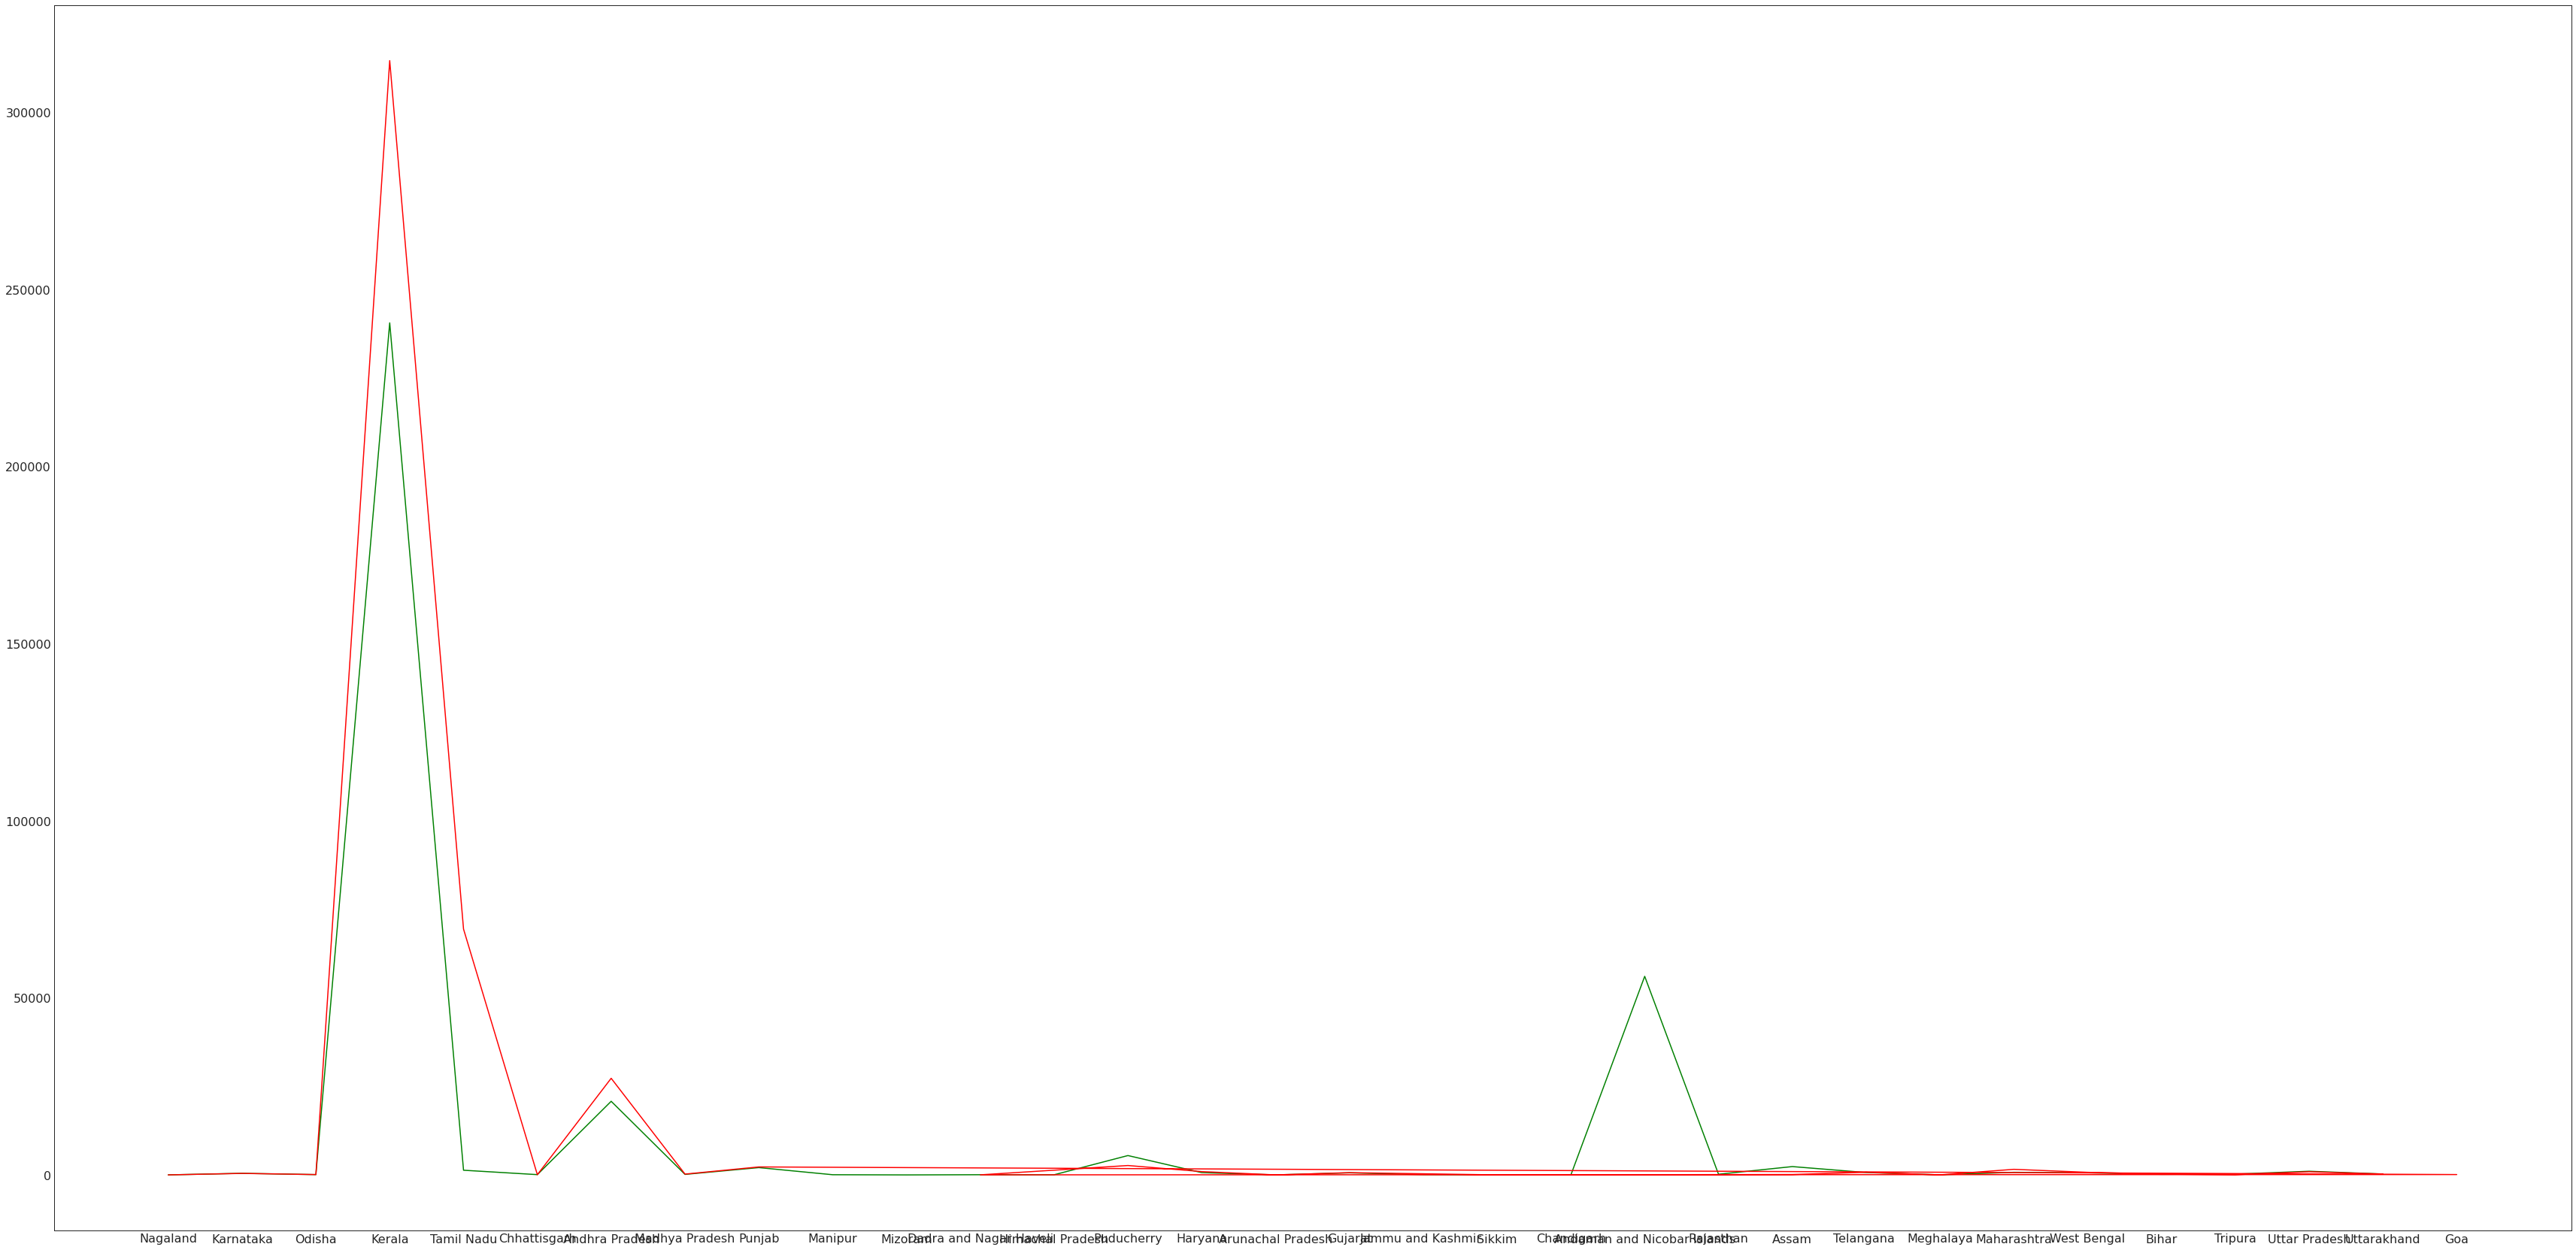

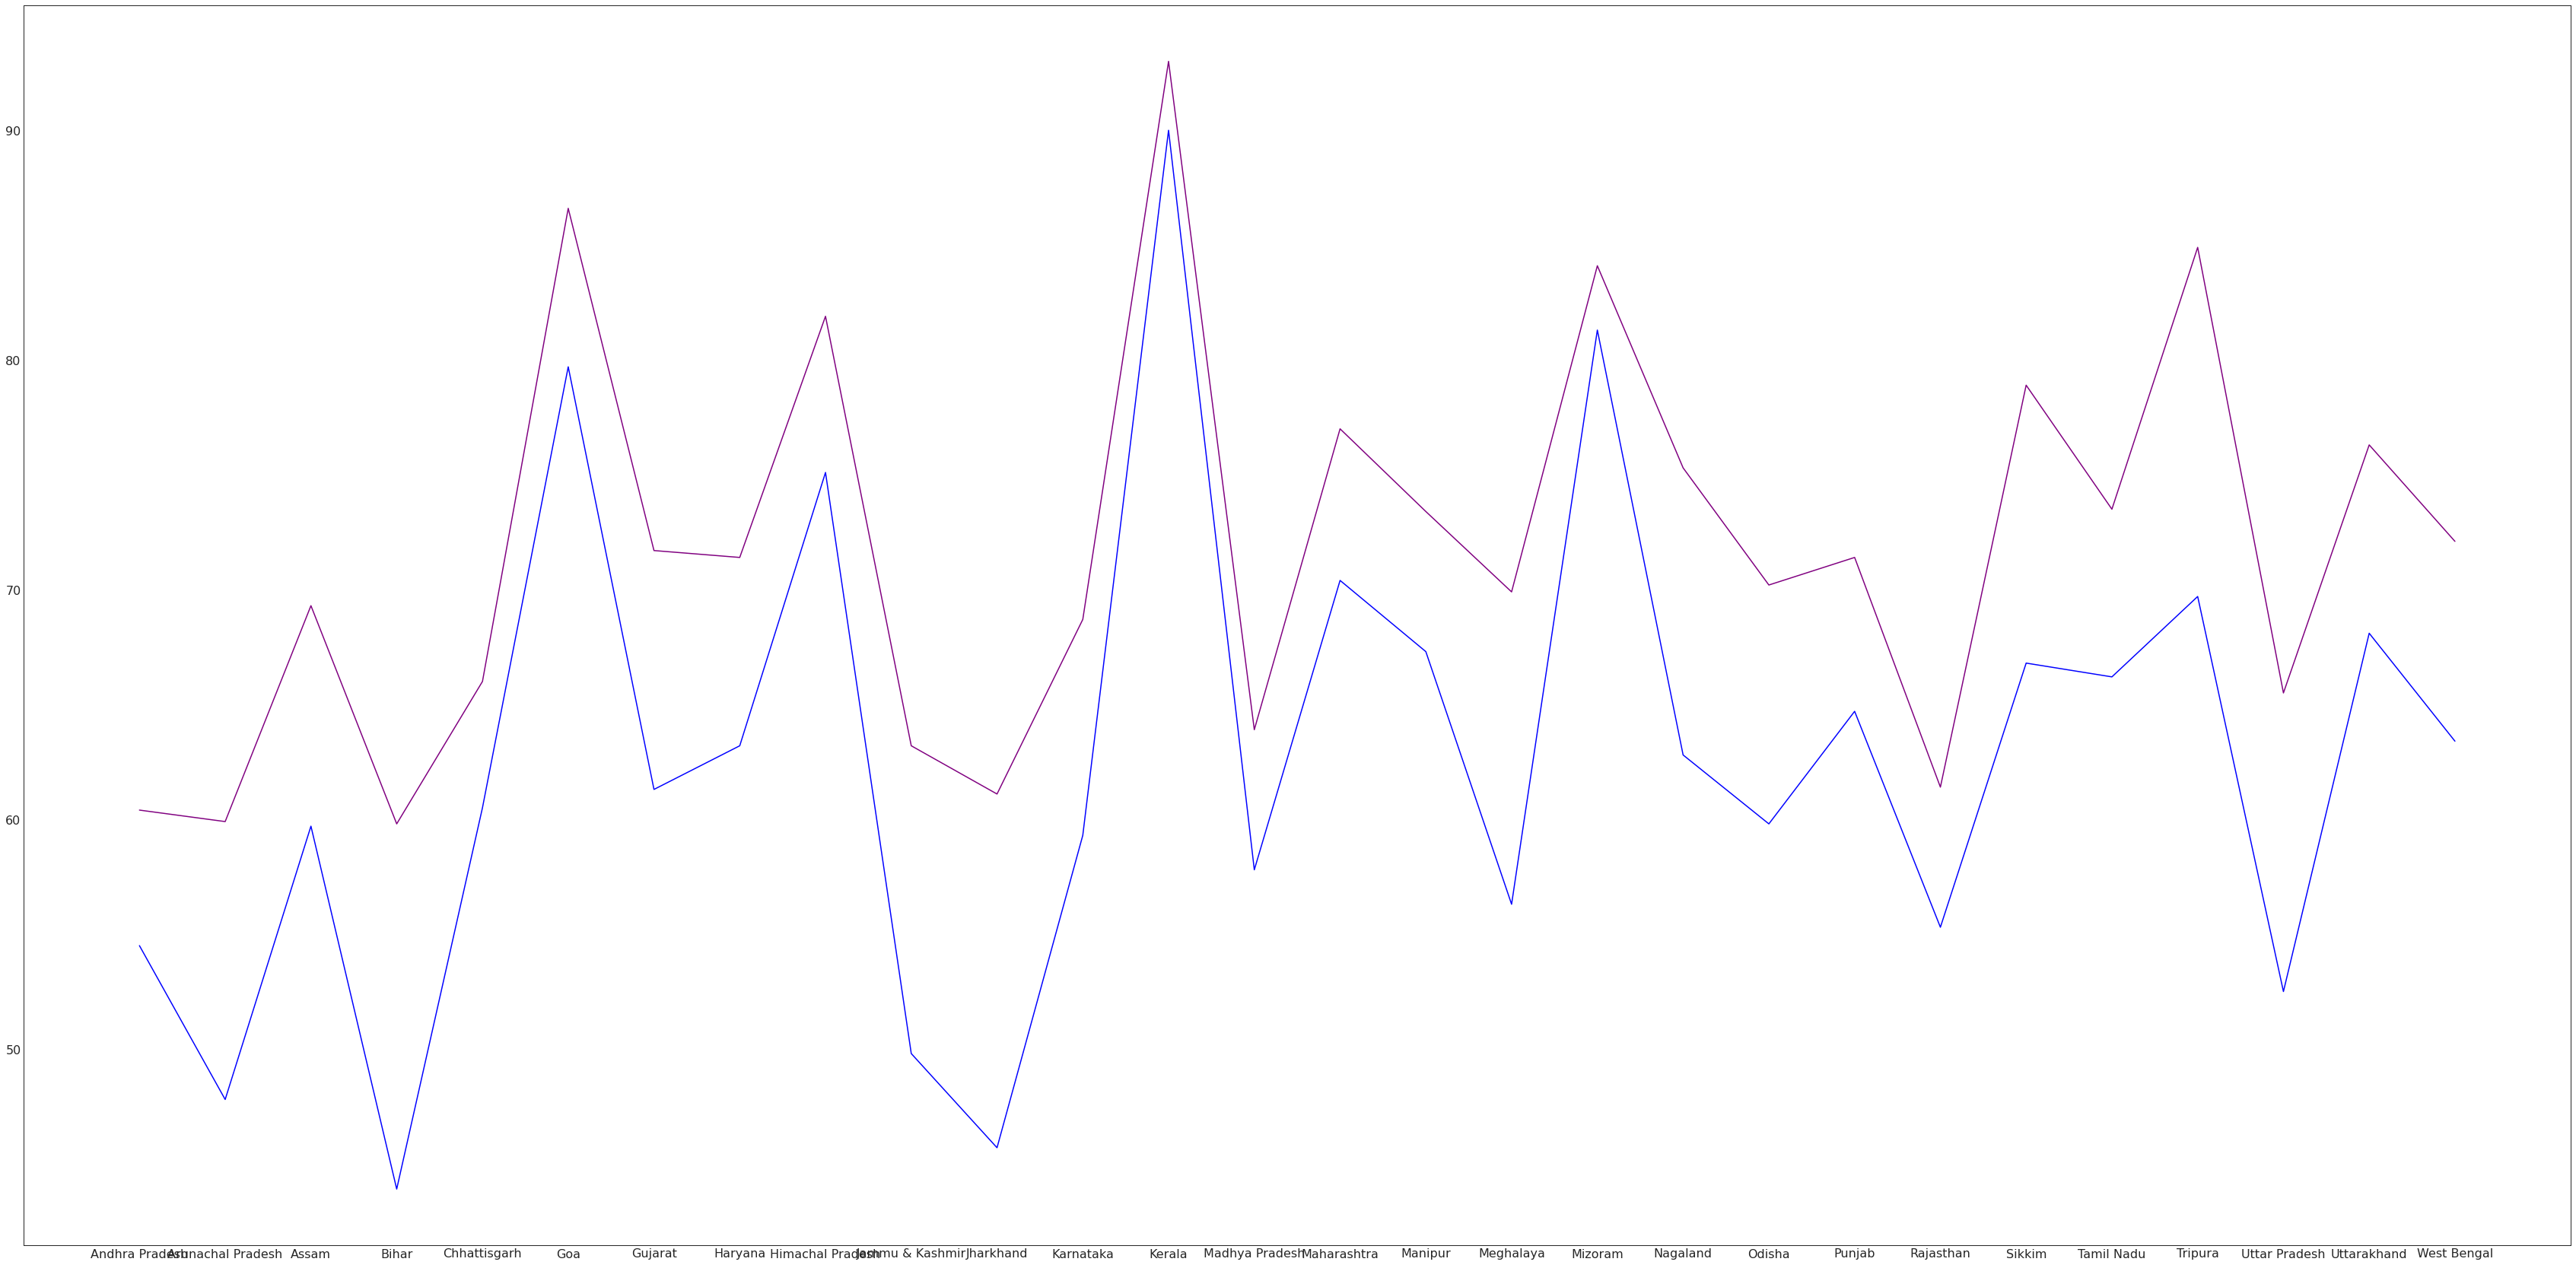

time: 4.76 s (started: 2021-12-10 03:57:21 +00:00)


In [29]:
df1 = filtered_crop_1.toPandas()
df2 = filtered_crop_11.toPandas()
df3 = filtered_lit.toPandas()

plt.figure(figsize=(60, 30))
plt.plot(df1["State_Name"],df1["totalScaledProduce"],'g')

plt.plot(df2["State_Name"],df2["totalScaledProduce"],'r')
plt.show()
plt.figure(figsize=(60, 30))
plt.plot(df3["Country_States_Union_Territories_Name"],df3["Literacy_Rate_Persons_Rural_2001"],'b')

plt.plot(df3["Country_States_Union_Territories_Name"],df3["Literacy_Rate_Persons_Rural_2011"],'purple')

plt.show()

In [30]:
#Crop Min Max Values 2001
crop_min_max_1 = filtered_crop_1.agg(min("totalScaledProduce"), max("totalScaledProduce"))
crop_min_1 = crop_min_max_1.distinct().first()[0]
crop_max_1 = crop_min_max_1.distinct().first()[1]

#Crop Min Max Values 2011
crop_min_max_11 = filtered_crop_11.agg(min("totalScaledProduce"), max("totalScaledProduce"))
crop_min_11 = crop_min_max_11.distinct().first()[0]
crop_max_11 = crop_min_max_11.distinct().first()[1]

#Literacy Min Max Values 2001
#We are using Literacy_Rate_Persons_Rural_2001 for now#
lit_rural_min_max_1 = filtered_lit.agg(min("Literacy_Rate_Persons_Rural_2001"), max("Literacy_Rate_Persons_Rural_2001"))
lit_min_1 = lit_rural_min_max_1.distinct().first()[0]
lit_max_1 = lit_rural_min_max_1.distinct().first()[1]

#Literacy Min Max Values 2011
#We are using Literacy_Rate_Persons_Rural_2011 for now#
lit_rural_min_max_11 = filtered_lit.agg(min("Literacy_Rate_Persons_Rural_2011"), max("Literacy_Rate_Persons_Rural_2011"))
lit_min_11 = lit_rural_min_max_11.distinct().first()[0]
lit_max_11 = lit_rural_min_max_11.distinct().first()[1]

time: 6.19 s (started: 2021-12-10 03:57:26 +00:00)


In [31]:
normalised_crop_1 = filtered_crop_1.withColumn("normalisedProduce", (100*(col("totalScaledProduce") - crop_min_1))/(crop_max_1 - crop_min_1)).select(col("State_Name"), col("normalisedProduce"))
normalised_crop_11 = filtered_crop_11.withColumn("normalisedProduce", (100*(col("totalScaledProduce") - crop_min_11))/(crop_max_11 - crop_min_11)).select(col("State_Name"), col("normalisedProduce"))

normalised_lit_1 = filtered_lit.withColumn("normalisedLiteracy2001", (100*(col("Literacy_Rate_Persons_Rural_2001") - lit_min_1))/(lit_max_1 - lit_min_1)).select(col("Country_States_Union_Territories_Name"), col("normalisedLiteracy2001"))
normalised_lit_11 = filtered_lit.withColumn("normalisedLiteracy2011", (100*(col("Literacy_Rate_Persons_Rural_2011") - lit_min_11))/(lit_max_11 - lit_min_11)).select(col("Country_States_Union_Territories_Name"), col("normalisedLiteracy2011"))

time: 91.8 ms (started: 2021-12-10 03:57:32 +00:00)


In [32]:
##
# CROP LITERACY 2001 #
##

normalised_crop_1 = filtered_crop_1.withColumn("normalisedProduce", (100*(col("totalScaledProduce") - crop_min_1))/(crop_max_1 - crop_min_1)).select(col("State_Name"), col("normalisedProduce"))

normalised_lit_1 = filtered_lit.withColumn("normalisedLiteracy2001", (100*(col("Literacy_Rate_Persons_Rural_2001") - lit_min_1))/(lit_max_1 - lit_min_1)).select(col("Country_States_Union_Territories_Name"), col("normalisedLiteracy2001"))

crop_literacy_1 = normalised_crop_1.join(normalised_lit_1, normalised_crop_1.State_Name == normalised_lit_1.Country_States_Union_Territories_Name).withColumn("divergence", abs(normalised_lit_1.normalisedLiteracy2001 - normalised_crop_1.normalisedProduce))
#crop_literacy_1.show(5)

##
# CROP LITERACY 2011 #
##

normalised_crop_11 = filtered_crop_11.withColumn("normalisedProduce", (100*(col("totalScaledProduce") - crop_min_11))/(crop_max_11 - crop_min_11)).select(col("State_Name"), col("normalisedProduce"))

normalised_lit_11 = filtered_lit.withColumn("normalisedLiteracy2011", (100*(col("Literacy_Rate_Persons_Rural_2011") - lit_min_11))/(lit_max_11 - lit_min_11)).orderBy("Country_States_Union_Territories_Name").select(col("Country_States_Union_Territories_Name"), col("normalisedLiteracy2011"))

crop_literacy_11 = normalised_crop_11.join(normalised_lit_11, normalised_crop_1.State_Name == normalised_lit_11.Country_States_Union_Territories_Name).withColumn("divergence", abs(normalised_lit_11.normalisedLiteracy2011 - normalised_crop_11.normalisedProduce))
#crop_literacy_11.show(5)

##
# CROP LITERACY OVERALL DIVERGENCE #
##
crop_literacy_divergence = crop_literacy_11.join(crop_literacy_1, crop_literacy_11.State_Name == crop_literacy_1.State_Name).withColumn("FinalDiv", (crop_literacy_11.divergence + crop_literacy_1.divergence)/2).orderBy(crop_literacy_11.State_Name).select(crop_literacy_11.State_Name, "FinalDiv")
average_overall_literacy = normalised_lit_1.join(normalised_lit_11, normalised_lit_1.Country_States_Union_Territories_Name == normalised_lit_11.Country_States_Union_Territories_Name).withColumn("avgLit", (normalised_lit_1.normalisedLiteracy2001+normalised_lit_11.normalisedLiteracy2011)/2).orderBy(normalised_lit_11.Country_States_Union_Territories_Name).select(normalised_lit_11.Country_States_Union_Territories_Name,col("avgLit"))
average_overall_literacy.show()
crop_literacy_divergence.show()

+-------------------------------------+------------------+
|Country_States_Union_Territories_Name|            avgLit|
+-------------------------------------+------------------+
|                       Andhra Pradesh|12.400360661735885|
|                    Arunachal Pradesh| 4.380537333716646|
|                                Assam|31.443888351671333|
|                                Bihar|               0.0|
|                         Chhattisgarh|27.341687792384292|
|                                  Goa| 79.19007918877244|
|                              Gujarat| 36.79370410056713|
|                              Haryana| 38.40263439876645|
|                     Himachal Pradesh| 67.12261192274522|
|                      Jammu & Kashmir|11.519614248752063|
|                            Jharkhand| 3.910108982568027|
|                            Karnataka|30.106434414447385|
|                               Kerala|             100.0|
|                       Madhya Pradesh| 21.2506207040744

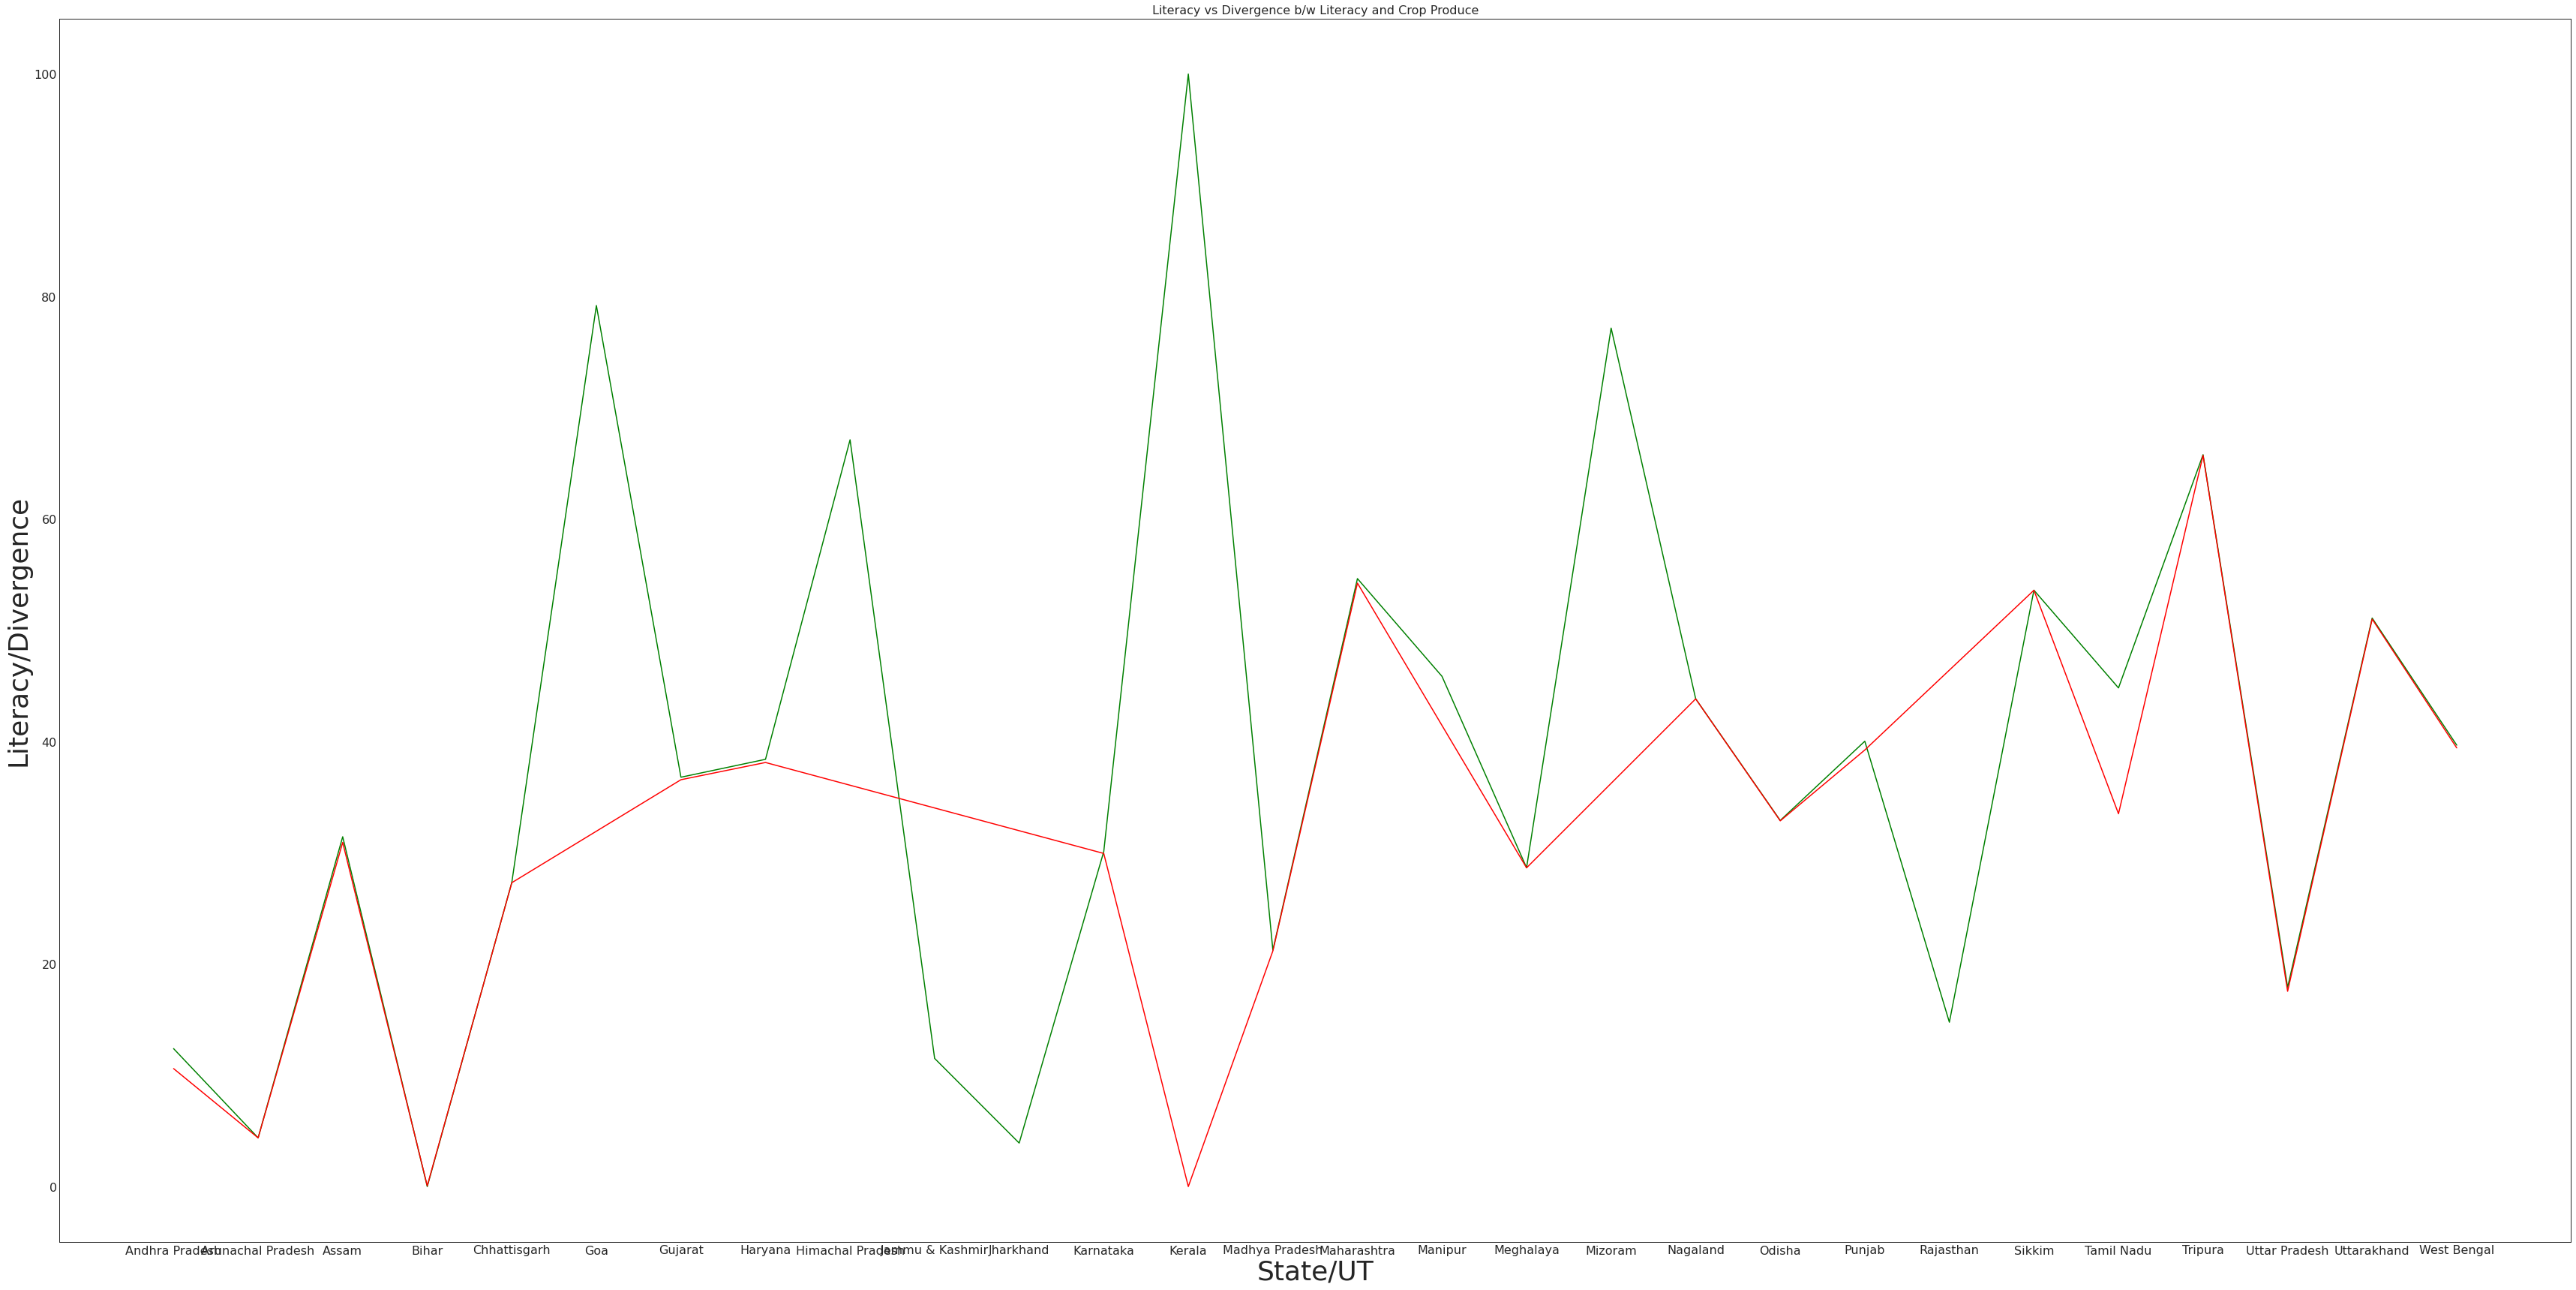

time: 5.45 s (started: 2021-12-10 03:57:35 +00:00)


In [33]:
plt.figure(figsize=(60, 30))
df = crop_literacy_divergence.toPandas()
df2 = average_overall_literacy.toPandas()
plt.plot(df2["Country_States_Union_Territories_Name"],df2["avgLit"],'g')

plt.plot(df["State_Name"],df["FinalDiv"], 'r')
plt.ylabel('Literacy/Divergence', fontsize=36)
plt.xlabel('State/UT', fontsize=36)
plt.title('Literacy vs Divergence b/w Literacy and Crop Produce', fontsize=16)



#plt.plot(df['B'], label='B', color='steelblue')
#plt.plot(df['C'], label='C', color='purple')
plt.show()


## Comparison of performance of crops Arecanut, Jowar, Sugarcane, Jute, Rice with Rainfall for periods 2000-14

This sections aims to find any relation between the crops that are majorly relying on rainfall for irrigation against their produce in the years 2000-14

### Exploration of Crop Production

In [34]:
# Filter data sets by year 2000-14
# between https://stackoverflow.com/a/45978382/2843359
cdf2000_14 = _cdf.withColumn("State_Name", trim(col("State_Name"))
    ).withColumn("Crop", trim(col("Crop"))
    ).withColumn("Crop_Year", col("Crop_Year").cast("integer")
    ).withColumn("Area", col("Area").cast("double")
    ).withColumn("Production", col("Production").cast("double")
    ).filter(col('Crop_Year').between(2000, 2014)
    )
# cdf2000_14.show(5)

# Filter for the crops
cdf_ajsjcr = cdf2000_14.filter(
        (col('Crop') == 'Arecanut')
    |   (col('Crop') == 'Jowar')
    |   (col('Crop') == 'Coconut')
    |   (col('Crop') == 'Sugarcane')
    |   (col('Crop') == 'Jute')
    |   (col('Crop') == 'Rice')
    )
# cdf_ajsjcr.show(5)

cdf_ajsjcr_state_wise = cdf_ajsjcr.select(
        col('State_Name'),
        col('Crop_Year'),
        col('Crop'),
        col('Area'),
        col('Production')
    ).groupBy(['State_Name', 'Crop_Year', 'Crop']
    ).agg(
        sum('Area').alias('Total_Area'),
        sum('Production').alias('Total_Production')
    ).sort(col('State_Name').desc(), col('Crop'), col('Crop_Year')
    ).withColumn('Avg_Yield', (col('Total_Production') / col('Total_Area'))
    )
cdf_ajsjcr_state_wise.show(5)

+-----------+---------+--------+----------+----------------+------------------+
| State_Name|Crop_Year|    Crop|Total_Area|Total_Production|         Avg_Yield|
+-----------+---------+--------+----------+----------------+------------------+
|West Bengal|     2000|Arecanut|    7773.0|         12191.0| 1.568377717740898|
|West Bengal|     2001|Arecanut|    9276.0|         14885.0|1.6046787408365675|
|West Bengal|     2002|Arecanut|    9081.0|         16568.0|1.8244686708512279|
|West Bengal|     2003|Arecanut|    9166.0|         18519.0|2.0204014837442723|
|West Bengal|     2005|Arecanut|    9363.0|         29287.0| 3.127950443234006|
+-----------+---------+--------+----------+----------------+------------------+
only showing top 5 rows

time: 2.27 s (started: 2021-12-10 03:57:41 +00:00)


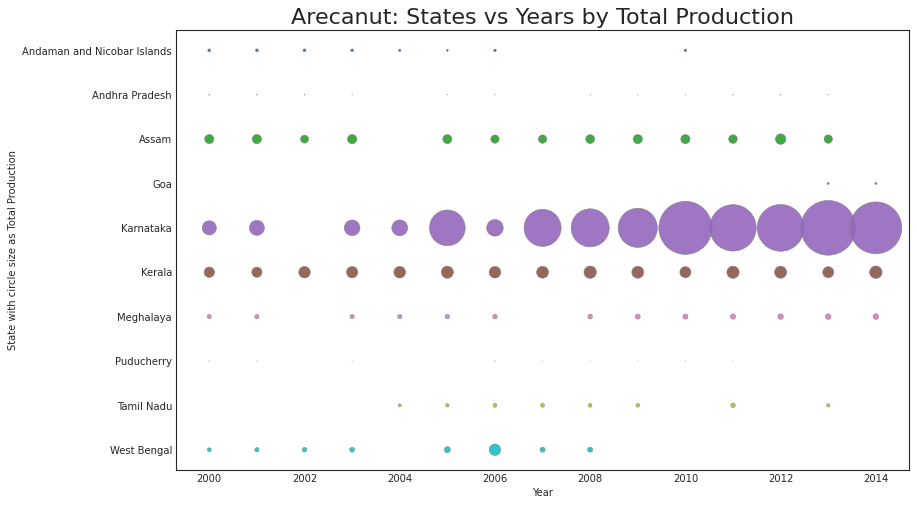

time: 3.49 s (started: 2021-12-10 03:57:43 +00:00)


In [35]:
## Arecanut
plt_data = cdf_ajsjcr_state_wise.filter(col('Crop') == 'Arecanut').toPandas()

# print(plt_data)

# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_centr = fig.add_subplot(grid[:-1, :-1])

# Scatterplot on main ax
ax_centr.scatter('Crop_Year', 
                 'State_Name',
                 s=plt_data.Total_Production/1000,
                 c=plt_data['State_Name'].astype('category').cat.codes,
                 alpha=.9,
                 data=plt_data,
                 cmap="tab10",
                 edgecolors='gray',
                 linewidths=.5)

# Decorations
ax_centr.set(title='Arecanut: States vs Years by Total Production', xlabel='Year', ylabel='State with circle size as Total Production')
ax_centr.title.set_fontsize(20)
for item in ([ax_centr.xaxis.label, ax_centr.yaxis.label] + ax_centr.get_xticklabels() + ax_centr.get_yticklabels()):
    item.set_fontsize(9)

plt.show()

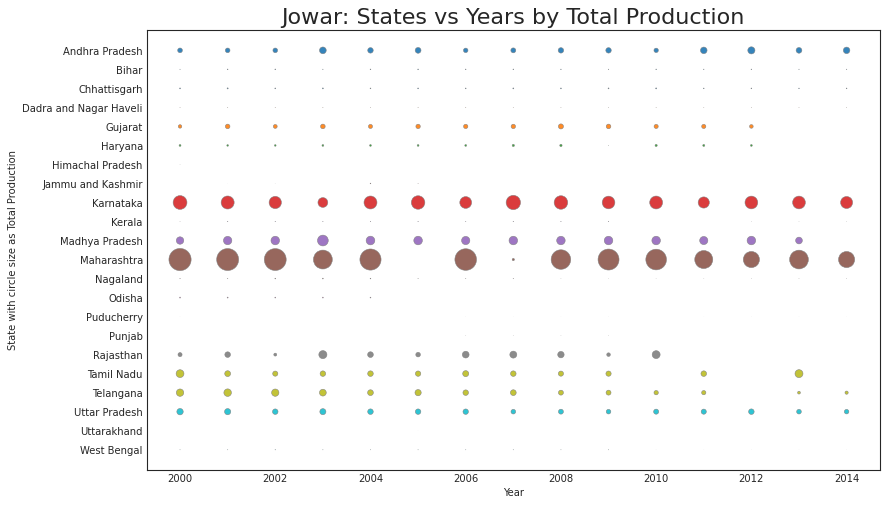

time: 4.33 s (started: 2021-12-10 03:57:47 +00:00)


In [36]:
## Jowar
plt_data = cdf_ajsjcr_state_wise.filter(col('Crop') == 'Jowar').toPandas()

# print(plt_data)

# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_centr = fig.add_subplot(grid[:-1, :-1])

# Scatterplot on main ax
ax_centr.scatter('Crop_Year', 
                 'State_Name',
                 s=plt_data.Total_Production/10000,
                 c=plt_data['State_Name'].astype('category').cat.codes,
                 alpha=.9,
                 data=plt_data,
                 cmap="tab10",
                 edgecolors='gray',
                 linewidths=.5)

# Decorations
ax_centr.set(title='Jowar: States vs Years by Total Production', xlabel='Year', ylabel='State with circle size as Total Production')
ax_centr.title.set_fontsize(20)
for item in ([ax_centr.xaxis.label, ax_centr.yaxis.label] + ax_centr.get_xticklabels() + ax_centr.get_yticklabels()):
    item.set_fontsize(9)

plt.show()

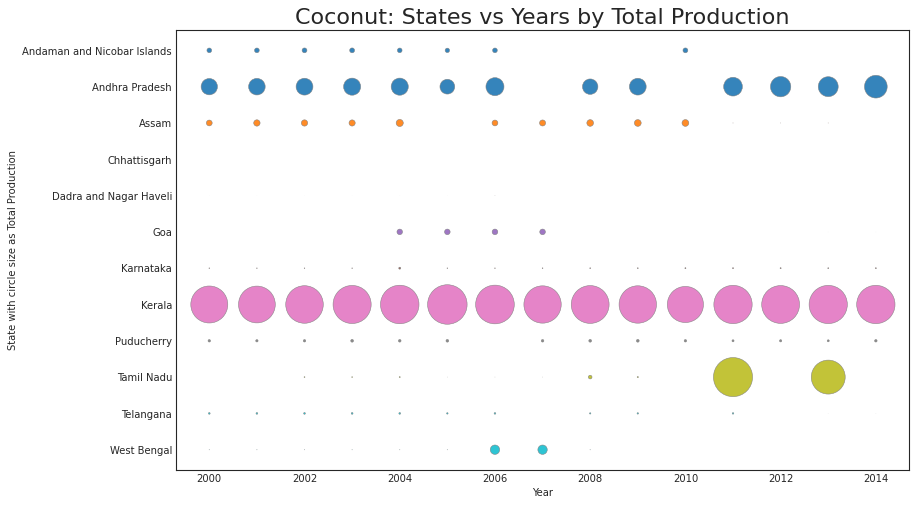

time: 3.29 s (started: 2021-12-10 03:57:51 +00:00)


In [37]:
## Coconut
plt_data = cdf_ajsjcr_state_wise.filter(col('Crop') == 'Coconut').toPandas()

# print(plt_data)

# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_centr = fig.add_subplot(grid[:-1, :-1])

# Scatterplot on main ax
ax_centr.scatter('Crop_Year', 
                 'State_Name',
                 s=plt_data.Total_Production/5000000,
                 c=plt_data['State_Name'].astype('category').cat.codes,
                 alpha=.9,
                 data=plt_data,
                 cmap="tab10",
                 edgecolors='gray',
                 linewidths=.5)

# Decorations
ax_centr.set(title='Coconut: States vs Years by Total Production', xlabel='Year', ylabel='State with circle size as Total Production')
ax_centr.title.set_fontsize(20)
for item in ([ax_centr.xaxis.label, ax_centr.yaxis.label] + ax_centr.get_xticklabels() + ax_centr.get_yticklabels()):
    item.set_fontsize(9)

plt.show()

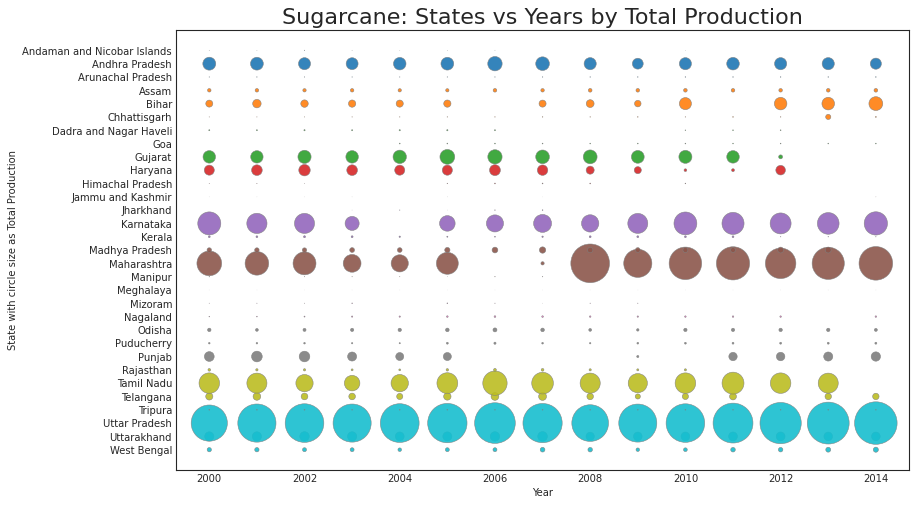

time: 4.3 s (started: 2021-12-10 03:57:54 +00:00)


In [38]:
## Sugarcane
plt_data = cdf_ajsjcr_state_wise.filter(col('Crop') == 'Sugarcane').toPandas()

# print(plt_data)

# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_centr = fig.add_subplot(grid[:-1, :-1])

# Scatterplot on main ax
ax_centr.scatter('Crop_Year', 
                 'State_Name',
                 s=plt_data.Total_Production/100000,
                 c=plt_data['State_Name'].astype('category').cat.codes,
                 alpha=.9,
                 data=plt_data,
                 cmap="tab10",
                 edgecolors='gray',
                 linewidths=.5)

# Decorations
ax_centr.set(title='Sugarcane: States vs Years by Total Production', xlabel='Year', ylabel='State with circle size as Total Production')
ax_centr.title.set_fontsize(20)
for item in ([ax_centr.xaxis.label, ax_centr.yaxis.label] + ax_centr.get_xticklabels() + ax_centr.get_yticklabels()):
    item.set_fontsize(9)

plt.show()

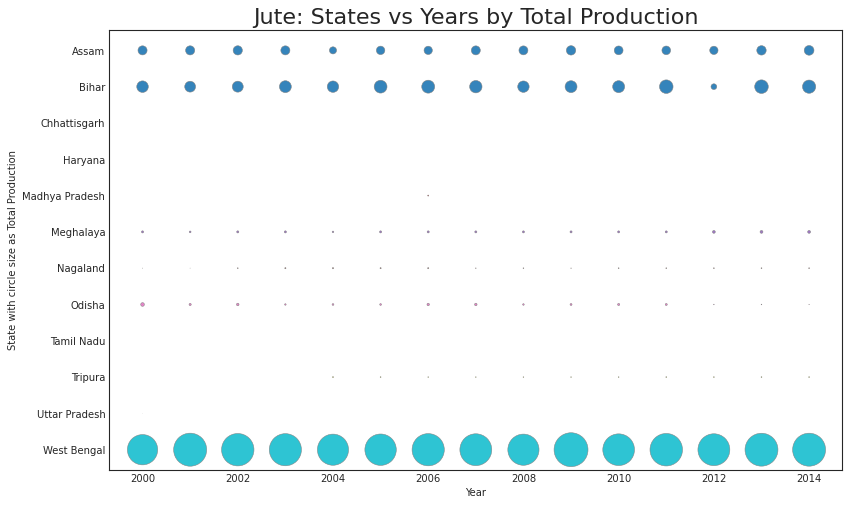

time: 3.28 s (started: 2021-12-10 03:57:59 +00:00)


In [39]:
## Jute
plt_data = cdf_ajsjcr_state_wise.filter(col('Crop') == 'Jute').toPandas()

# print(plt_data)

# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_centr = fig.add_subplot(grid[:-1, :-1])

# Scatterplot on main ax
ax_centr.scatter('Crop_Year', 
                 'State_Name',
                 s=plt_data.Total_Production/10000,
                 c=plt_data['State_Name'].astype('category').cat.codes,
                 alpha=.9,
                 data=plt_data,
                 cmap="tab10",
                 edgecolors='gray',
                 linewidths=.5)

# Decorations
ax_centr.set(title='Jute: States vs Years by Total Production', xlabel='Year', ylabel='State with circle size as Total Production')
ax_centr.title.set_fontsize(20)
for item in ([ax_centr.xaxis.label, ax_centr.yaxis.label] + ax_centr.get_xticklabels() + ax_centr.get_yticklabels()):
    item.set_fontsize(9)

plt.show()

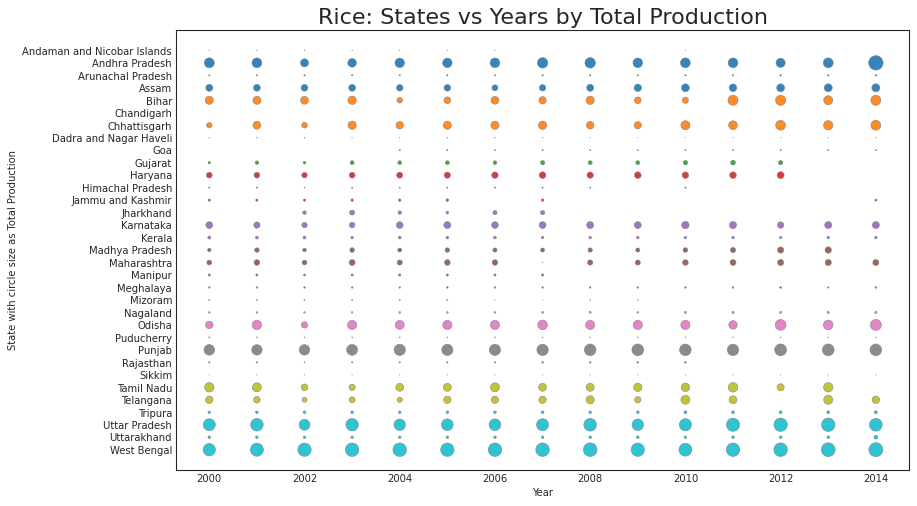

time: 4.22 s (started: 2021-12-10 03:58:02 +00:00)


In [40]:
## Rice
plt_data = cdf_ajsjcr_state_wise.filter(col('Crop') == 'Rice').toPandas()

# print(plt_data)

# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_centr = fig.add_subplot(grid[:-1, :-1])

# Scatterplot on main ax
ax_centr.scatter('Crop_Year', 
                 'State_Name',
                 s=plt_data.Total_Production/100000,
                 c=plt_data['State_Name'].astype('category').cat.codes,
                 alpha=.9,
                 data=plt_data,
                 cmap="tab10",
                 edgecolors='gray',
                 linewidths=.5)

# Decorations
ax_centr.set(title='Rice: States vs Years by Total Production', xlabel='Year', ylabel='State with circle size as Total Production')
ax_centr.title.set_fontsize(20)
for item in ([ax_centr.xaxis.label, ax_centr.yaxis.label] + ax_centr.get_xticklabels() + ax_centr.get_yticklabels()):
    item.set_fontsize(9)

plt.show()

### Exploration of Rainfall in Rainy season by States in for 2000-14

We are considering June, July, August, September, October as rainy season due to spread of rainfall in India.

In [41]:
rdf_2000_14 = _rdf.filter(col('YEAR').between(2000, 2014)
    ).select('SUBDIVISION', 'YEAR', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT'
    ).withColumn('Rainfall', col('JUN') + col('JUL') + col('AUG') + col('SEP') + col('OCT')
    ).sort(col('SUBDIVISION').desc(), col('YEAR'))
rdf_2000_14.show(5)


+------------------+----+-----+-----+-----+-----+----+-----------------+
|       SUBDIVISION|YEAR|  JUN|  JUL|  AUG|  SEP| OCT|         Rainfall|
+------------------+----+-----+-----+-----+-----+----+-----------------+
|WEST UTTAR PRADESH|2000|143.0|251.2|238.9| 79.1| 0.0|            712.2|
|WEST UTTAR PRADESH|2001|164.4|282.0|122.1| 26.7|16.3|            611.5|
|WEST UTTAR PRADESH|2002| 29.0| 29.6|252.3|218.1| 6.7|            535.7|
|WEST UTTAR PRADESH|2003| 74.1|315.6|214.2|356.6| 0.7|961.2000000000002|
|WEST UTTAR PRADESH|2004| 59.3|124.2|250.5| 84.0|60.5|            578.5|
+------------------+----+-----+-----+-----+-----+----+-----------------+
only showing top 5 rows

time: 242 ms (started: 2021-12-10 03:58:06 +00:00)


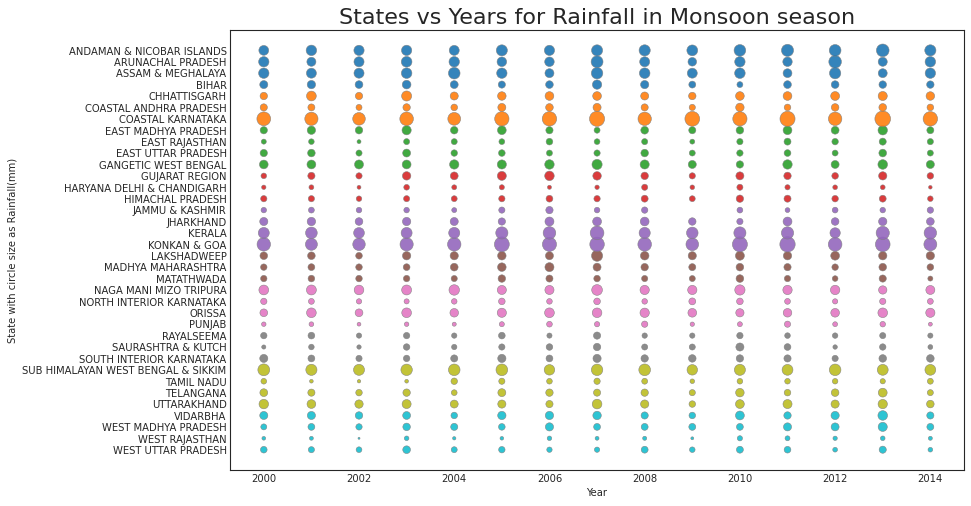

time: 1.44 s (started: 2021-12-10 03:58:06 +00:00)


In [42]:
## Arecanut
plt_data = rdf_2000_14.toPandas()

# print(plt_data)

# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_centr = fig.add_subplot(grid[:-1, :-1])

# Scatterplot on main ax
ax_centr.scatter('YEAR', 
                 'SUBDIVISION',
                 s=plt_data.Rainfall/20,
                 c=plt_data['SUBDIVISION'].astype('category').cat.codes,
                 alpha=.9,
                 data=plt_data,
                 cmap="tab10",
                 edgecolors='gray',
                 linewidths=.5)

# Decorations
ax_centr.set(title='States vs Years for Rainfall in Monsoon season', xlabel='Year', ylabel='State with circle size as Rainfall(mm)')
ax_centr.title.set_fontsize(20)
for item in ([ax_centr.xaxis.label, ax_centr.yaxis.label] + ax_centr.get_xticklabels() + ax_centr.get_yticklabels()):
    item.set_fontsize(9)

plt.show()

### Average Rainfall and Years with Above/Below Average Rainfall

In [43]:
# Compute the 
rdf_avg = rdf_2000_14.select('SUBDIVISION', 'Rainfall'
    ).groupBy('SUBDIVISION'
    ).agg(avg('Rainfall').alias('avg_rainfall')
    ).withColumnRenamed('SUBDIVISION', 'SUBDIVISION_AVG'
    ).orderBy('SUBDIVISION_AVG'
    )
# rdf_avg.show(5)

rdf_avg = rdf_avg.join(rdf_2000_14, rdf_avg.SUBDIVISION_AVG == rdf_2000_14.SUBDIVISION
    ).withColumn('RainInSeason', col('JUN') + col('JUL') + col('AUG') + col('SEP') + col('OCT')
    ).select(col('SUBDIVISION'), col('YEAR'), col('Rainfall'), col('avg_rainfall')
    ).withColumn('IsAboveAvgRainfall', when(col('Rainfall') >= col('avg_rainfall'), 1).otherwise(lit(0))
    ).sort(col('SUBDIVISION'), col('YEAR'))
rdf_avg.show(5)

+--------------------+----+------------------+------------------+------------------+
|         SUBDIVISION|YEAR|          Rainfall|      avg_rainfall|IsAboveAvgRainfall|
+--------------------+----+------------------+------------------+------------------+
|ANDAMAN & NICOBAR...|2000|1565.3999999999999|1961.2333333333333|                 0|
|ANDAMAN & NICOBAR...|2001|            1783.0|1961.2333333333333|                 0|
|ANDAMAN & NICOBAR...|2002|            1694.5|1961.2333333333333|                 0|
|ANDAMAN & NICOBAR...|2003|            1716.5|1961.2333333333333|                 0|
|ANDAMAN & NICOBAR...|2004|1616.1000000000001|1961.2333333333333|                 0|
+--------------------+----+------------------+------------------+------------------+
only showing top 5 rows

time: 3.27 s (started: 2021-12-10 03:58:08 +00:00)


### Merging Rainfall and Crop Data sets

Note: Some of the states are mapped to multiple regions. In such cases, the average rainfall for all the regions in a state are considered together

In [44]:
df_cr_merged = cdf_ajsjcr_state_wise.join(
        rdf_avg, 
        rc_state_compare_udf(
            cdf_ajsjcr_state_wise.State_Name,
            rdf_avg.SUBDIVISION,
            cdf_ajsjcr_state_wise.Crop_Year,
            rdf_avg.YEAR
        )
    ).drop('SUBDIVISION', 'YEAR', 'IsAboveAvgRainfall'
    ).groupBy(['State_Name', 'Crop_Year', 'Crop']
    ).agg(
        first('Total_Area').alias('Total_Area'),
        first('Total_Production').alias('Total_Production'),
        first('Avg_Yield').alias('Avg_Yield'),
        avg('Rainfall').alias('Rainfall'),
        avg('avg_rainfall').alias('Avg_Rainfall'),
    ).sort(col('State_Name'), col('Crop_Year'), col('Crop')
    )

df_cr_merged.show(5)

avg_rainfall = df_cr_merged.groupBy().agg(avg('Avg_Rainfall').alias('Avg_Rainfall'))
avg_r = avg_rainfall.collect()[0].Avg_Rainfall

+--------------------+---------+---------+----------+----------------+------------------+------------------+------------------+
|          State_Name|Crop_Year|     Crop|Total_Area|Total_Production|         Avg_Yield|          Rainfall|      Avg_Rainfall|
+--------------------+---------+---------+----------+----------------+------------------+------------------+------------------+
|Andaman and Nicob...|     2000| Arecanut|    4354.0|          7200.0|1.6536518144235186|1565.3999999999999|1961.2333333333333|
|Andaman and Nicob...|     2000|  Coconut|   25160.0|           8.9E7|3537.3608903020668|1565.3999999999999|1961.2333333333333|
|Andaman and Nicob...|     2000|     Rice|   10881.0|         32184.0| 2.957816377171216|1565.3999999999999|1961.2333333333333|
|Andaman and Nicob...|     2000|Sugarcane|     142.0|          3738.0|26.323943661971832|1565.3999999999999|1961.2333333333333|
|Andaman and Nicob...|     2001| Arecanut|    4354.0|          7300.0|1.6766192007349563|            178

### Visualization of Crop Data with Rainfall

In [45]:
## Arecanut
df_temp = df_cr_merged.filter((col('Crop') == 'Arecanut')
    ).drop('State_Name', 'Crop', 'Total_Area', 'Total_Production', 'Avg_Rainfall'
    ).groupBy('Crop_Year'
    ).agg(
        avg('Avg_Yield').alias('Avg_Yield'),
        avg('Rainfall').alias('Rainfall'),
    ).withColumn('Rainfall', col('Rainfall')/1000
    ).sort('Crop_Year'
    )

df_temp = df_temp.drop('Avg_Rainfall'
    ).withColumn('Avg_Rainfall', lit(avg_r)
    ).withColumn('Avg_Rainfall', col('Avg_Rainfall')/1000
    )

df_temp.show(5)

dataSet = df_temp.toPandas();

+---------+------------------+------------------+------------------+
|Crop_Year|         Avg_Yield|          Rainfall|      Avg_Rainfall|
+---------+------------------+------------------+------------------+
|     2000|1.5646886550161991|1.4552562500000001|1.2047129875523304|
|     2001|1.4418781803421767|1.4043270833333334|1.2047129875523304|
|     2002| 1.350604465160962|1.2589333333333332|1.2047129875523304|
|     2003| 1.256827157278557|1.2838037037037038|1.2047129875523304|
|     2004|1.2312398743975361|1.5617133333333333|1.2047129875523304|
+---------+------------------+------------------+------------------+
only showing top 5 rows

time: 23.2 s (started: 2021-12-10 03:58:40 +00:00)


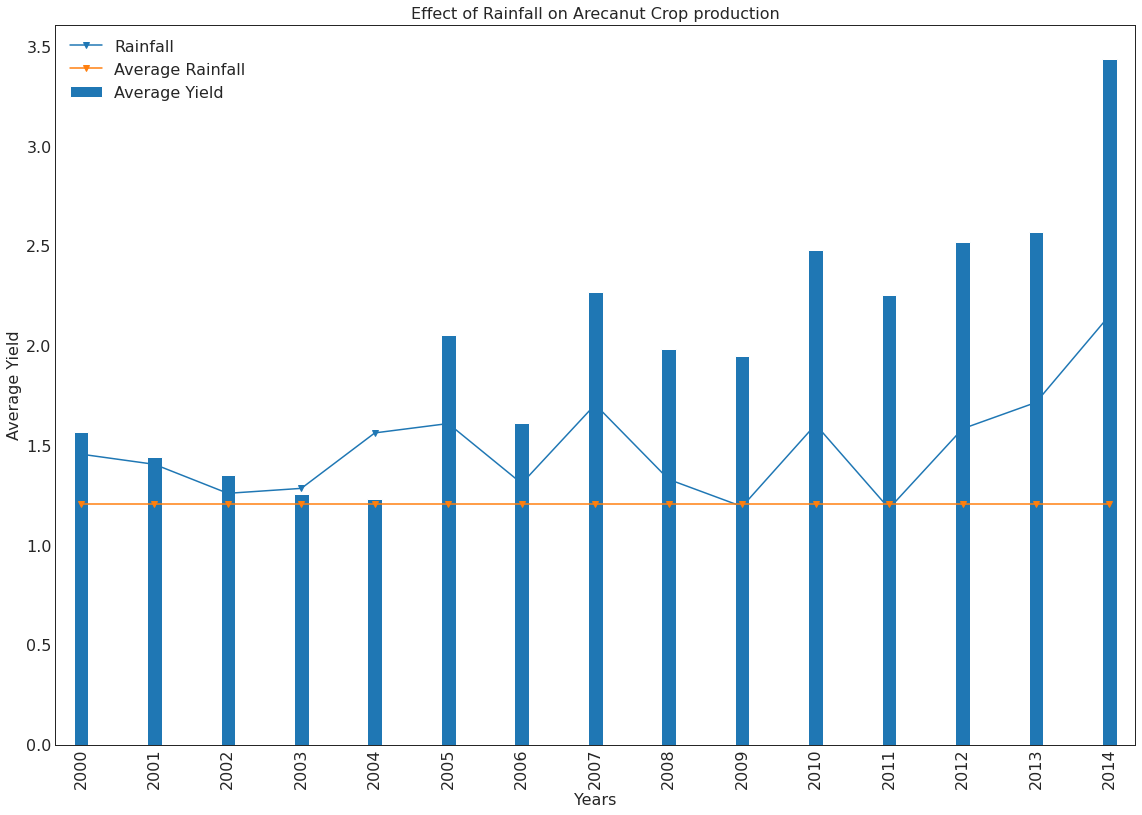

time: 440 ms (started: 2021-12-10 03:59:03 +00:00)


In [46]:
ax = dataSet[['Rainfall', 'Avg_Rainfall']]\
    .plot(linestyle='solid',
          marker='v',
          title='Effect of Rainfall on Arecanut Crop production')
dataSet['Avg_Yield'].plot(kind='bar', ax = ax, width=0.2)

ax.set_xticklabels(dataSet['Crop_Year'])

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


set_size(15,10)
ax.set_xlabel("Years")
ax.set_ylabel("Average Yield")
ax.legend(["Rainfall", "Average Rainfall", "Average Yield"]);
plt.show()

In [47]:
## Jowar
df_temp = df_cr_merged.filter((col('Crop') == 'Jowar')
    ).drop('State_Name', 'Crop', 'Total_Area', 'Total_Production', 'Avg_Rainfall'
    ).groupBy('Crop_Year'
    ).agg(
        avg('Avg_Yield').alias('Avg_Yield'),
        avg('Rainfall').alias('Rainfall'),
    ).withColumn('Rainfall', col('Rainfall')/1000
    ).sort('Crop_Year'
    )

df_temp = df_temp.drop('Avg_Rainfall'
    ).withColumn('Avg_Rainfall', lit(avg_r)
    ).withColumn('Avg_Rainfall', col('Avg_Rainfall')/1000
    )

df_temp.show(5)

dataSet = df_temp.toPandas();

+---------+------------------+------------------+------------------+
|Crop_Year|         Avg_Yield|          Rainfall|      Avg_Rainfall|
+---------+------------------+------------------+------------------+
|     2000|0.7162924571088535|0.8965701754385966|1.2047129875523304|
|     2001|0.7776530769521215| 1.014348148148148|1.2047129875523304|
|     2002|0.7795108660536686|0.8094083333333333|1.2047129875523304|
|     2003|0.8694864846907403| 1.111679411764706|1.2047129875523304|
|     2004|0.8160765324801064|0.9532675925925925|1.2047129875523304|
+---------+------------------+------------------+------------------+
only showing top 5 rows

time: 24.6 s (started: 2021-12-10 03:59:03 +00:00)


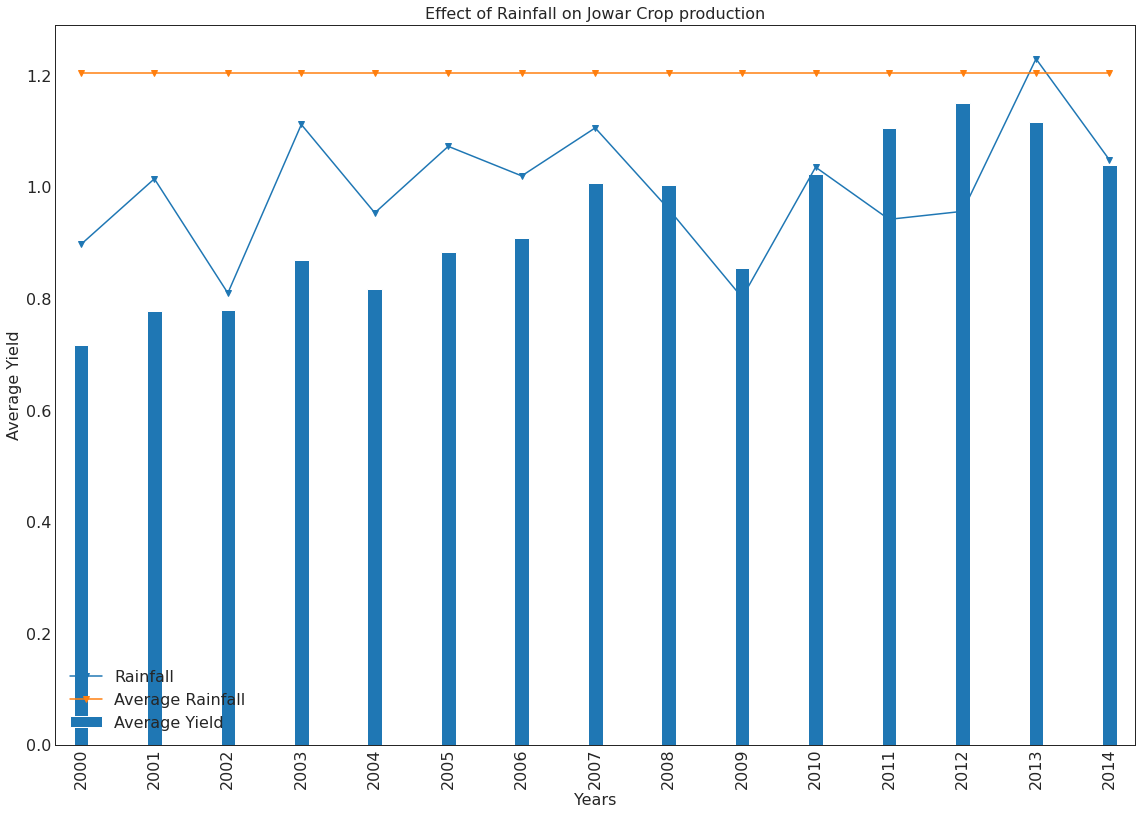

time: 466 ms (started: 2021-12-10 03:59:28 +00:00)


In [48]:
ax = dataSet[['Rainfall', 'Avg_Rainfall']]\
    .plot(linestyle='solid',
          marker='v',
          title='Effect of Rainfall on Jowar Crop production')
dataSet['Avg_Yield'].plot(kind='bar', ax = ax, width=0.2)

ax.set_xticklabels(dataSet['Crop_Year'])

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


set_size(15,10)
ax.set_xlabel("Years")
ax.set_ylabel("Average Yield")
ax.legend(["Rainfall", "Average Rainfall", "Average Yield"]);
plt.show()

In [49]:
## Jute
df_temp = df_cr_merged.filter((col('Crop') == 'Jute')
    ).drop('State_Name', 'Crop', 'Total_Area', 'Total_Production', 'Avg_Rainfall'
    ).groupBy('Crop_Year'
    ).agg(
        avg('Avg_Yield').alias('Avg_Yield'),
        avg('Rainfall').alias('Rainfall'),
    ).withColumn('Rainfall', col('Rainfall')/1000
    ).sort('Crop_Year'
    )

df_temp = df_temp.drop('Avg_Rainfall'
    ).withColumn('Avg_Rainfall', lit(avg_r)
    ).withColumn('Avg_Rainfall', col('Avg_Rainfall')/1000
    )

df_temp.show(5)

dataSet = df_temp.toPandas();

+---------+-----------------+------------------+------------------+
|Crop_Year|        Avg_Yield|          Rainfall|      Avg_Rainfall|
+---------+-----------------+------------------+------------------+
|     2000|6.876942882815842|           1.37235|1.2047129875523304|
|     2001|7.582463020989877|1.5203416666666665|1.2047129875523304|
|     2002|8.619447594073854|           1.39575|1.2047129875523304|
|     2003|8.772467250013914|1.6083249999999998|1.2047129875523304|
|     2004|8.218779637387987|1.7042428571428572|1.2047129875523304|
+---------+-----------------+------------------+------------------+
only showing top 5 rows

time: 22 s (started: 2021-12-10 03:59:28 +00:00)


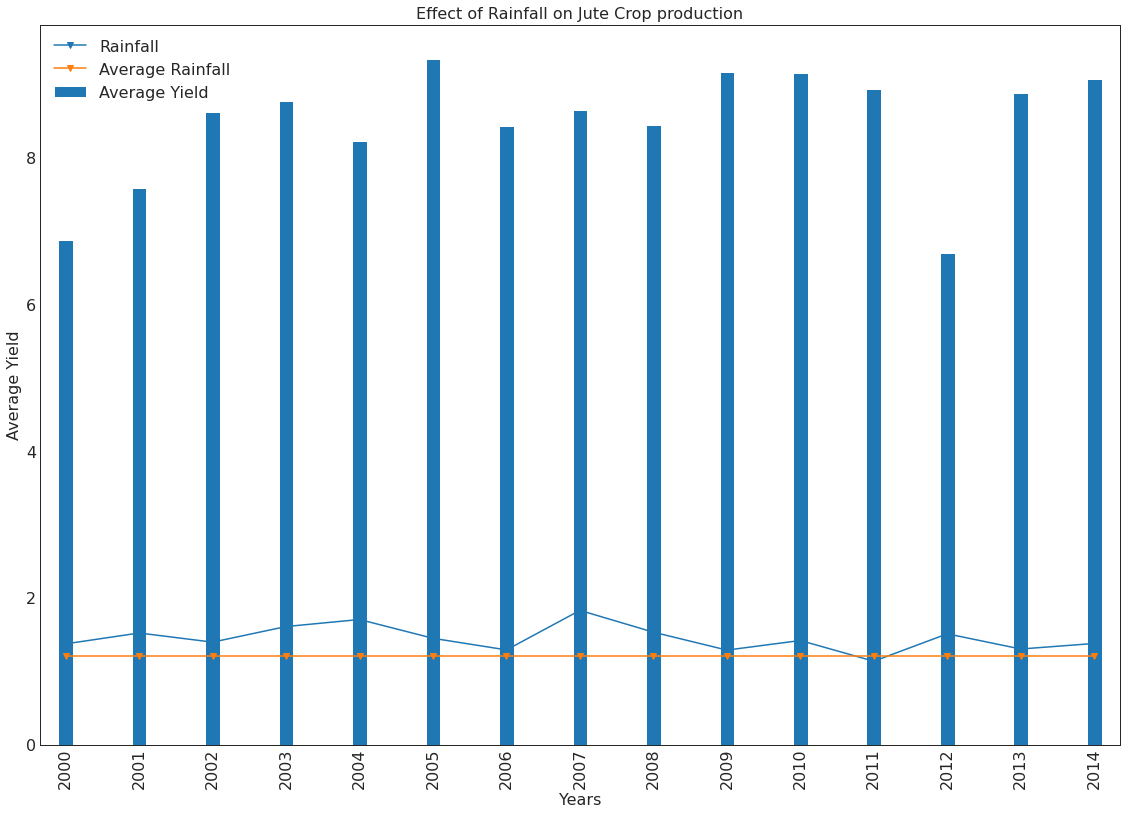

time: 416 ms (started: 2021-12-10 03:59:50 +00:00)


In [50]:
ax = dataSet[['Rainfall', 'Avg_Rainfall']]\
    .plot(linestyle='solid',
          marker='v',
          title='Effect of Rainfall on Jute Crop production')
dataSet['Avg_Yield'].plot(kind='bar', ax = ax, width=0.2)

ax.set_xticklabels(dataSet['Crop_Year'])

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


set_size(15,10)
ax.set_xlabel("Years")
ax.set_ylabel("Average Yield")
ax.legend(["Rainfall", "Average Rainfall", "Average Yield"]);
plt.show()

In [51]:
## Rice
df_temp = df_cr_merged.filter((col('Crop') == 'Rice')
    ).drop('State_Name', 'Crop', 'Total_Area', 'Total_Production', 'Avg_Rainfall'
    ).groupBy('Crop_Year'
    ).agg(
        avg('Avg_Yield').alias('Avg_Yield'),
        avg('Rainfall').alias('Rainfall'),
    ).withColumn('Rainfall', col('Rainfall')/1000
    ).sort('Crop_Year'
    )

df_temp = df_temp.drop('Avg_Rainfall'
    ).withColumn('Avg_Rainfall', lit(avg_r)
    ).withColumn('Avg_Rainfall', col('Avg_Rainfall')/1000
    )

df_temp.show(5)

dataSet = df_temp.toPandas();

+---------+------------------+------------------+------------------+
|Crop_Year|         Avg_Yield|          Rainfall|      Avg_Rainfall|
+---------+------------------+------------------+------------------+
|     2000| 2.018555684499864|1.0749817204301075|1.2047129875523304|
|     2001|2.1373996848099104|1.1042505376344083|1.2047129875523304|
|     2002| 1.925417122068887|0.9655015625000001|1.2047129875523304|
|     2003| 2.120054920086141|      1.1753671875|1.2047129875523304|
|     2004|2.1198868760045735|1.1922489898989905|1.2047129875523304|
+---------+------------------+------------------+------------------+
only showing top 5 rows

time: 23.7 s (started: 2021-12-10 03:59:51 +00:00)


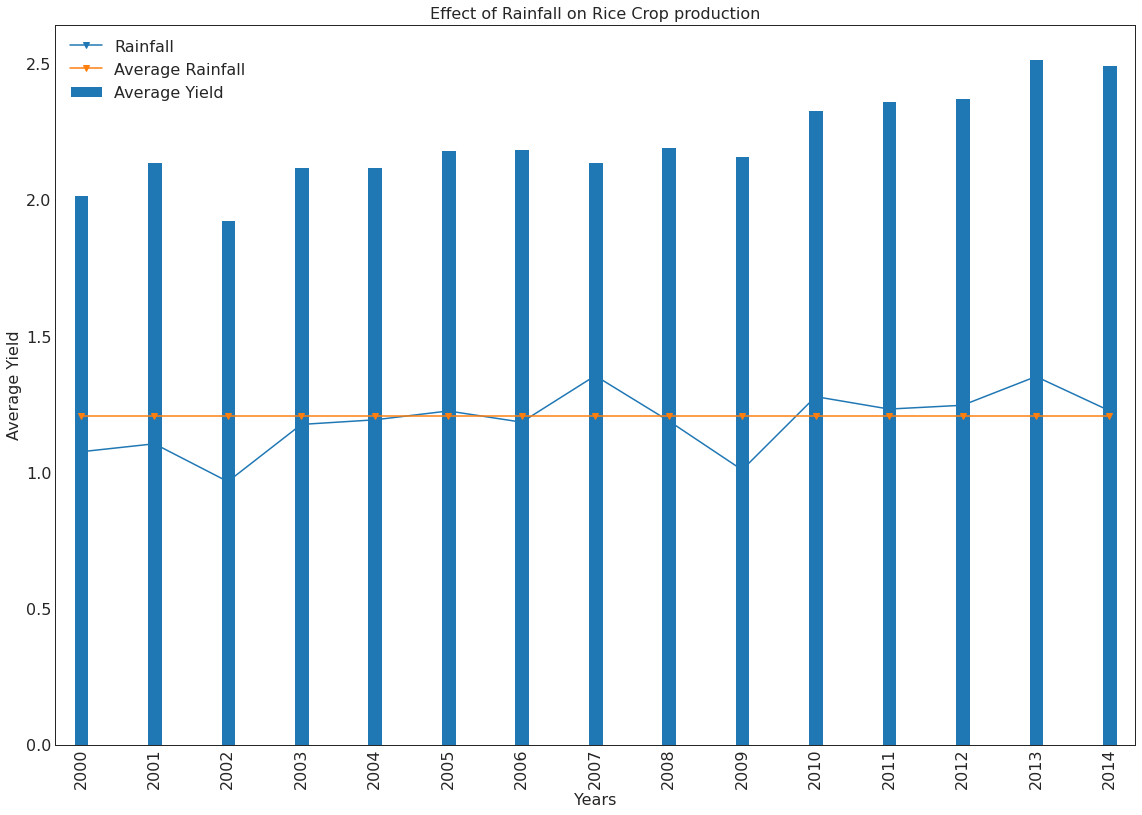

time: 458 ms (started: 2021-12-10 04:00:15 +00:00)


In [52]:
ax = dataSet[['Rainfall', 'Avg_Rainfall']]\
    .plot(linestyle='solid',
          marker='v',
          title='Effect of Rainfall on Rice Crop production')
dataSet['Avg_Yield'].plot(kind='bar', ax = ax, width=0.2)

ax.set_xticklabels(dataSet['Crop_Year'])

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


set_size(15,10)
ax.set_xlabel("Years")
ax.set_ylabel("Average Yield")
ax.legend(["Rainfall", "Average Rainfall", "Average Yield"]);
plt.show()